# Space Tourism


In [1]:
base_dir = '../'

# 1. Data pre-processing


## Importing libraries


In [2]:
import numpy as np
import pandas as pd
import shap as shap
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from uszipcode import SearchEngine
from pandas_profiling import ProfileReport

# settings to display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning


## Reading data


In [3]:
data = pd.read_csv(base_dir + 'data/modelingData_SpaceTourism_modified.csv')
data['zip'] = data['zip'].astype(int)
data.head()

id  choice    zip  year_birth  gender  annual_income  \
0   1       0  55906        1976       1              8   
1   1       0  55906        1976       1              8   
2   1       1  55906        1976       1              8   
3   1       0  55906        1976       1              8   
4   2       1  55906        1976       1              8   

   household_annual_income  number_vehicles  level_education  work_type  \
0                        9                1                7          1   
1                        9                1                7          1   
2                        9                1                7          1   
3                        9                1                7          1   
4                        9                1                7          1   

   children_home  household_type  status_in_household  type_residence  \
0              2               1                    1               1   
1              2               1                    1               1   
2              2               1                    1               1   
3              2               1                    1               1   
4              2               1                    1               1   

   housing_tenure_type  origin  race  citizenship  risk_activities_sports  \
0                    1       2     3            1                       1   
1                    1       2     3            1                       1   
2                    1       2     3            1                       1   
3                    1       2     3            1                       1   
4                    1       2     3            1                       1   

   price_attribute  availability  probability_fatality  training  \
0                2             0                     1         0   
1                2             0                     0         1   
2                0             0                     0         0   
3               -1            -1                    -1        -1   
4                2             0                     0         1   

   number_passengers  takeoff_location  price_dollars alternative  
0                  0                 0       453125.0  suborbital  
1                  0                 0       453125.0     orbital  
2                  1                 0         3750.0   moon_trip  
3                 -1                -1            0.0  not_travel  
4                  0                 0       453125.0  suborbital

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       8640 non-null   int64  
 1   choice                   8640 non-null   int64  
 2   zip                      8640 non-null   int64  
 3   year_birth               8640 non-null   int64  
 4   gender                   8640 non-null   int64  
 5   annual_income            8640 non-null   int64  
 6   household_annual_income  8640 non-null   int64  
 7   number_vehicles          8640 non-null   int64  
 8   level_education          8640 non-null   int64  
 9   work_type                8640 non-null   int64  
 10  children_home            8640 non-null   int64  
 11  household_type           8640 non-null   int64  
 12  status_in_household      8640 non-null   int64  
 13  type_residence           8640 non-null   int64  
 14  housing_tenure_type     

## Feature Engineering


In [5]:
cleanup_nums = {
    'gender': {
        1: 'male',
        2: 'female'
    },
    #! ADD ORDINAL CATEGORIES
    'annual_income': {
        1: 'less_than_10k',
        2: '10k_15k',
        3: '15k_25k',
        4: '25k_35k',
        5: '35k_50k',
        6: '50k_75k',
        7: '75k_100k',
        8: '100k_150k',
        9: '150k_200k',
        10: 'more_than_200k'
    },
    #! ADD ORDINAL CATEGORIES
    'household_annual_income': {
        1: 'less_than_10k',
        2: '10k_15k',
        3: '15k_25k',
        4: '25k_35k',
        5: '35k_50k',
        6: '50k_75k',
        7: '75k_100k',
        8: '100k_150k',
        9: '150k_200k',
        10: 'more_than_200k'
    },
    #! ADD ORDINAL CATEGORIES
    'number_vehicles': {
        1: '1_car',
        2: '2_cars',
        3: '3_cars',
        4: '4_or_more_cars'
    },
    #! ADD ORDINAL CATEGORIES
    'level_education': {
        1: 'less_9th_grade',
        2: '9th_12th_grade_nodiploma',
        3: 'high_school_graduate',
        4: 'some_college',
        5: 'associate_degree',
        6: 'bachelor_degree',
        7: 'grad_prof_degree'
    },
    'work_type': {
        1: 'private',
        2: 'government',
        3: 'self_employed',
        4: 'unpaid_work'
    },
    #! ADD ORDINAL CATEGORIES
    'children_home': {
        1: '0_children',
        2: '1_child',
        3: '2_children',
        4: '3_children',
        5: '4_children',
        6: '5_children_or_more'
    },
    'household_type': {
        1: 'couple_with_children',
        2: 'couple_no_children',
        3: 'male_with_children',
        4: 'male_no_children',
        5: 'female_with_children',
        6: 'female_no_children',
        7: 'alone',
        8: 'other'
    },
    'status_in_household': {
        1: 'head',
        2: 'spouse',
        3: 'child',
        4: 'other'
    },
    'type_residence': {
        1: 'house',
        2: 'apartment',
        3: 'other'
    },
    'housing_tenure_type': {
        1: 'own',
        2: 'rent'
    },
    'origin': {
        1: 'hispanic',
        2: 'non_hispanic'
    },
    'race': {
        1: 'white',
        2: 'black',
        3: 'asian',
        4: 'hawaian_pacific',
        5: 'other_race',
        6: 'two_or_more_races'
    },
    'citizenship': {
        1: 'us_citizen',
        2: 'other'
    },
    #! ADD ORDINAL CATEGORIES
    'risk_activities_sports': {
        1: 'never',
        2: 'rarely',
        3: 'often'
    },
    'price_attribute': {
        0: '3_perc_annual_income',
        1: '50_perc_annual_income',
        2: '362_perc_annual_income',
        -1: np.nan
    },
    'availability': {
        0: 'immediate',
        1: 'in_5_years',
        -1: np.nan
    },
    'probability_fatality': {
        0: 0.5,
        1: 7.5,
        -1: np.nan
    },
    'training': {
        0: 'no',
        1: 'yes',
        -1: np.nan
    },
    'number_passengers': {
        0: 'one',
        1: 'more_than_one',
        -1: np.nan
    },
    'takeoff_location': {
        0: 'usa',
        1: 'other',
        -1: np.nan
    }
}

In [6]:
data = data.replace(cleanup_nums)

data.head()

id  choice    zip  year_birth gender annual_income household_annual_income  \
0   1       0  55906        1976   male     100k_150k               150k_200k   
1   1       0  55906        1976   male     100k_150k               150k_200k   
2   1       1  55906        1976   male     100k_150k               150k_200k   
3   1       0  55906        1976   male     100k_150k               150k_200k   
4   2       1  55906        1976   male     100k_150k               150k_200k   

  number_vehicles   level_education work_type children_home  \
0           1_car  grad_prof_degree   private       1_child   
1           1_car  grad_prof_degree   private       1_child   
2           1_car  grad_prof_degree   private       1_child   
3           1_car  grad_prof_degree   private       1_child   
4           1_car  grad_prof_degree   private       1_child   

         household_type status_in_household type_residence  \
0  couple_with_children                head          house   
1  couple_with_children                head          house   
2  couple_with_children                head          house   
3  couple_with_children                head          house   
4  couple_with_children                head          house   

  housing_tenure_type        origin   race citizenship risk_activities_sports  \
0                 own  non_hispanic  asian  us_citizen                  never   
1                 own  non_hispanic  asian  us_citizen                  never   
2                 own  non_hispanic  asian  us_citizen                  never   
3                 own  non_hispanic  asian  us_citizen                  never   
4                 own  non_hispanic  asian  us_citizen                  never   

          price_attribute availability  probability_fatality training  \
0  362_perc_annual_income    immediate                   7.5       no   
1  362_perc_annual_income    immediate                   0.5      yes   
2    3_perc_annual_income    immediate                   0.5       no   
3                     NaN          NaN                   NaN      NaN   
4  362_perc_annual_income    immediate                   0.5      yes   

  number_passengers takeoff_location  price_dollars alternative  
0               one              usa       453125.0  suborbital  
1               one              usa       453125.0     orbital  
2     more_than_one              usa         3750.0   moon_trip  
3               NaN              NaN            0.0  not_travel  
4               one              usa       453125.0  suborbital

In [7]:
# Creating a column with 4 categories for each alternative

list_alt = [1, 2, 3, 4]
data['list_alt'] = np.tile(list_alt, len(data) // len(list_alt))


In [8]:
# Creating four dataframes with the different alternatives

data_suborbital = data[data['list_alt'] == 1]
data_orbital = data[data['list_alt'] == 2]
data_moon_trip = data[data['list_alt'] == 3]
data_not_travel = data[data['list_alt'] == 4]

data_suborbital = data_suborbital.rename(
    columns={
        'choice': 'suborbital',
        'price_attribute': 'price_attribute_suborbital',
        'availability': 'availability_suborbital',
        'probability_fatality': 'probability_fatality_suborbital',
        'training': 'training_suborbital',
        'number_passengers': 'number_passengers_suborbital',
        'takeoff_location': 'takeoff_location_suborbital',
        'price_dollars': 'price_dollars_suborbital',
    })
data_orbital = data_orbital.rename(
    columns={
        'choice': 'orbital',
        'price_attribute': 'price_attribute_orbital',
        'availability': 'availability_orbital',
        'probability_fatality': 'probability_fatality_orbital',
        'training': 'training_orbital',
        'number_passengers': 'number_passengers_orbital',
        'takeoff_location': 'takeoff_location_orbital',
        'price_dollars': 'price_dollars_orbital',
    })
data_moon_trip = data_moon_trip.rename(
    columns={
        'choice': 'moon_trip',
        'price_attribute': 'price_attribute_moon_trip',
        'availability': 'availability_moon_trip',
        'probability_fatality': 'probability_fatality_moon_trip',
        'training': 'training_moon_trip',
        'number_passengers': 'number_passengers_moon_trip',
        'takeoff_location': 'takeoff_location_moon_trip',
        'price_dollars': 'price_dollars_moon_trip',
    })
data_not_travel = data_not_travel.rename(
    columns={
        'choice': 'not_travel',
        'price_attribute': 'price_attribute_not_travel',
        'availability': 'availability_not_travel',
        'probability_fatality': 'probability_fatality_not_travel',
        'training': 'training_not_travel',
        'number_passengers': 'number_passengers_not_travel',
        'takeoff_location': 'takeoff_location_not_travel',
        'price_dollars': 'price_dollars_not_travel',
    })


In [9]:
# Merging the dataframes
merged_data = pd.merge(pd.merge(
    pd.merge(data_suborbital,
             data_orbital[[
                 'id', 'orbital', 'price_attribute_orbital',
                 'availability_orbital', 'probability_fatality_orbital',
                 'training_orbital', 'number_passengers_orbital',
                 'takeoff_location_orbital', 'price_dollars_orbital'
             ]],
             on='id',
             suffixes=('_suborbital', '_suborbital')),
    data_moon_trip[[
        'id', 'moon_trip', 'price_attribute_moon_trip',
        'availability_moon_trip', 'probability_fatality_moon_trip',
        'training_moon_trip', 'number_passengers_moon_trip',
        'takeoff_location_moon_trip', 'price_dollars_moon_trip'
    ]],
    on='id',
    suffixes=('', '_moon_trip')),
                       data_not_travel[['id', 'not_travel']],
                       on='id',
                       suffixes=('', '_not_travel'))
merged_data.head()

# Creating the column with the choice
merged_data['choice'] = merged_data[[
    'suborbital', 'orbital', 'moon_trip', 'not_travel'
]].idxmax(axis=1)

# Putting the choice in first place
choice_column = merged_data.pop('choice')
merged_data.insert(0, 'choice', choice_column)


In [10]:
# Changing year_birth for age
merged_data['age'] = 2022 - merged_data['year_birth']

# Transforming age to generation
merged_data['generation_age'] = np.where(
    merged_data['year_birth'] < 1928, 'greater_generation',
    np.where(
        merged_data['year_birth'] < 1946, 'traditionalist',
        np.where(
            merged_data['year_birth'] < 1964, 'baby_boomers',
            np.where(
                merged_data['year_birth'] < 1976, 'gen_x',
                np.where(merged_data['year_birth'] < 1995, 'millenials',
                         'centennials')))))

merged_data = merged_data.drop(columns=['year_birth'])


In [11]:
merged_data['generation_age'].value_counts().sort_index()

baby_boomers     216
centennials      312
gen_x            492
millenials      1140
Name: generation_age, dtype: int64

In [12]:
def city(zip):
    try:
        engine = SearchEngine()
        return engine.by_zipcode(zip).major_city
    except:
        return np.nan


def state(zip):
    try:
        engine = SearchEngine()
        return engine.by_zipcode(zip).state
    except:
        return np.nan

In [13]:
# Assigning the zipcode to the city
engine = SearchEngine()
merged_data['city'] = merged_data['zip'].apply(city)
merged_data['state'] = merged_data['zip'].apply(state)


In [14]:
# Aggregating states using https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States#/media/File:Census_Regions_and_Division_of_the_United_States.svg
dict_states = {
    'west': [
        'AZ', 'CA', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'OR', 'WA', 'AK',
        'HI'
    ],
    'midwest':
    ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH'],
    'south': [
        'TX', 'LA', 'MS', 'AL', 'AR', 'OK', 'FL', 'GA', 'KY', 'NC', 'SC', 'TN',
        'VA', 'WV', 'DC', 'MD', 'DE'
    ],
    'northeast': ['NY', 'PA', 'NJ', 'CT', 'RI', 'MA', 'VT', 'NH', 'ME']
}


def argcontains(item):
    for i, v in dict_states.items():
        if item in v:
            return i
    return np.nan


merged_data['region'] = merged_data['state'].map(argcontains)


In [15]:
# Dropping the unnecessary columns
merged_data = merged_data.drop(columns=[
    'id', 'alternative', 'list_alt', 'suborbital', 'orbital', 'moon_trip',
    'not_travel'
])

In [16]:
merged_data.head()

choice    zip gender annual_income household_annual_income  \
0   moon_trip  55906   male     100k_150k               150k_200k   
1  suborbital  55906   male     100k_150k               150k_200k   
2   moon_trip  55906   male     100k_150k               150k_200k   
3   moon_trip  55906   male     100k_150k               150k_200k   
4  suborbital  55906   male     100k_150k               150k_200k   

  number_vehicles   level_education work_type children_home  \
0           1_car  grad_prof_degree   private       1_child   
1           1_car  grad_prof_degree   private       1_child   
2           1_car  grad_prof_degree   private       1_child   
3           1_car  grad_prof_degree   private       1_child   
4           1_car  grad_prof_degree   private       1_child   

         household_type status_in_household type_residence  \
0  couple_with_children                head          house   
1  couple_with_children                head          house   
2  couple_with_children                head          house   
3  couple_with_children                head          house   
4  couple_with_children                head          house   

  housing_tenure_type        origin   race citizenship risk_activities_sports  \
0                 own  non_hispanic  asian  us_citizen                  never   
1                 own  non_hispanic  asian  us_citizen                  never   
2                 own  non_hispanic  asian  us_citizen                  never   
3                 own  non_hispanic  asian  us_citizen                  never   
4                 own  non_hispanic  asian  us_citizen                  never   

  price_attribute_suborbital availability_suborbital  \
0     362_perc_annual_income               immediate   
1     362_perc_annual_income               immediate   
2      50_perc_annual_income              in_5_years   
3       3_perc_annual_income              in_5_years   
4      50_perc_annual_income              in_5_years   

   probability_fatality_suborbital training_suborbital  \
0                              7.5                  no   
1                              0.5                 yes   
2                              7.5                 yes   
3                              7.5                  no   
4                              0.5                 yes   

  number_passengers_suborbital takeoff_location_suborbital  \
0                          one                         usa   
1                          one                         usa   
2                          one                         usa   
3                more_than_one                         usa   
4                more_than_one                         usa   

   price_dollars_suborbital price_attribute_orbital availability_orbital  \
0                  453125.0  362_perc_annual_income            immediate   
1                  453125.0  362_perc_annual_income            immediate   
2                   62500.0  362_perc_annual_income           in_5_years   
3                    3750.0   50_perc_annual_income            immediate   
4                   62500.0   50_perc_annual_income            immediate   

   probability_fatality_orbital training_orbital number_passengers_orbital  \
0                           0.5              yes                       one   
1                           0.5              yes             more_than_one   
2                           0.5               no                       one   
3                           7.5               no                       one   
4                           0.5               no             more_than_one   

  takeoff_location_orbital  price_dollars_orbital price_attribute_moon_trip  \
0                      usa               453125.0      3_perc_annual_income   
1                    other               453125.0    362_perc_annual_income   
2                    other               453125.0     50_perc_annual_income   
3                    other                62500.0   

In [17]:
data = merged_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160 entries, 0 to 2159
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   choice                           2160 non-null   object 
 1   zip                              2160 non-null   int64  
 2   gender                           2160 non-null   object 
 3   annual_income                    2160 non-null   object 
 4   household_annual_income          2160 non-null   object 
 5   number_vehicles                  2160 non-null   object 
 6   level_education                  2160 non-null   object 
 7   work_type                        2160 non-null   object 
 8   children_home                    2160 non-null   object 
 9   household_type                   2160 non-null   object 
 10  status_in_household              2160 non-null   object 
 11  type_residence                   2160 non-null   object 
 12  housing_tenure_type 

In [18]:
# The following zipcodes do not have information about city and state

data_without_region = data[data['region'].isnull()]
data_without_region['zip'].unique()

array([10429, 70028, 19632, 53427, 54321])

In [19]:
data['region'].value_counts(normalize=True, dropna=False)

west         0.361111
south        0.333333
northeast    0.166667
midwest      0.100000
NaN          0.038889
Name: region, dtype: float64

Not too imbalanced.


In [20]:
# Creating additional features because Rodrigo suggested me to do so

## probability_fatality
data['average_probability_fatality'] = data[[
    'probability_fatality_orbital', 'probability_fatality_suborbital',
    'probability_fatality_moon_trip'
]].mean(axis=1)
data['delta_probability_fatality_orbital'] = data[
    'average_probability_fatality'] - data['probability_fatality_orbital']
data['delta_probability_fatality_suborbital'] = data[
    'average_probability_fatality'] - data['probability_fatality_suborbital']
data['delta_probability_fatality_moon_trip'] = data[
    'average_probability_fatality'] - data['probability_fatality_moon_trip']

## price_attribute
data['average_price_dollars'] = data[[
    'price_dollars_orbital', 'price_dollars_suborbital',
    'price_dollars_moon_trip'
]].mean(axis=1)
data['delta_price_dollars_orbital'] = data['average_price_dollars'] - data[
    'price_dollars_orbital']
data['delta_price_dollars_suborbital'] = data['average_price_dollars'] - data[
    'price_dollars_suborbital']
data['delta_price_dollars_moon_trip'] = data['average_price_dollars'] - data[
    'price_dollars_moon_trip']

# Dropping features because Rodrigo suggested me to do so
data = data.drop(columns=[
    'zip', 'probability_fatality_orbital', 'probability_fatality_suborbital',
    'probability_fatality_moon_trip', 'price_dollars_orbital',
    'price_dollars_suborbital', 'price_dollars_moon_trip'
],
                 axis=1)


## Quality analysis


In [21]:
print('Data shape: ', data.shape)
data.head()

Data shape:  (2160, 44)


choice gender annual_income household_annual_income number_vehicles  \
0   moon_trip   male     100k_150k               150k_200k           1_car   
1  suborbital   male     100k_150k               150k_200k           1_car   
2   moon_trip   male     100k_150k               150k_200k           1_car   
3   moon_trip   male     100k_150k               150k_200k           1_car   
4  suborbital   male     100k_150k               150k_200k           1_car   

    level_education work_type children_home        household_type  \
0  grad_prof_degree   private       1_child  couple_with_children   
1  grad_prof_degree   private       1_child  couple_with_children   
2  grad_prof_degree   private       1_child  couple_with_children   
3  grad_prof_degree   private       1_child  couple_with_children   
4  grad_prof_degree   private       1_child  couple_with_children   

  status_in_household type_residence housing_tenure_type        origin   race  \
0                head          house                 own  non_hispanic  asian   
1                head          house                 own  non_hispanic  asian   
2                head          house                 own  non_hispanic  asian   
3                head          house                 own  non_hispanic  asian   
4                head          house                 own  non_hispanic  asian   

  citizenship risk_activities_sports price_attribute_suborbital  \
0  us_citizen                  never     362_perc_annual_income   
1  us_citizen                  never     362_perc_annual_income   
2  us_citizen                  never      50_perc_annual_income   
3  us_citizen                  never       3_perc_annual_income   
4  us_citizen                  never      50_perc_annual_income   

  availability_suborbital training_suborbital number_passengers_suborbital  \
0               immediate                  no                          one   
1               immediate                 yes                          one   
2              in_5_years                 yes                          one   
3              in_5_years                  no                more_than_one   
4              in_5_years                 yes                more_than_one   

  takeoff_location_suborbital price_attribute_orbital availability_orbital  \
0                         usa  362_perc_annual_income            immediate   
1                         usa  362_perc_annual_income            immediate   
2                         usa  362_perc_annual_income           in_5_years   
3                         usa   50_perc_annual_income            immediate   
4                         usa   50_perc_annual_income            immediate   

  training_orbital number_passengers_orbital takeoff_location_orbital  \
0              yes                       one                      usa   
1              yes             more_than_one                    other   
2               no                       one                    other   
3               no                       one                    other   
4               no             more_than_one                    other   

  price_attribute_moon_trip availability_moon_trip training_moon_trip  \
0      3_perc_annual_income              immediate                 no   
1    362_perc_annual_income             in_5_years                 no   
2     50_perc_annual_income              immediate                 no   
3     50_perc_annual_income             in_5_years                yes   
4      3_perc_annual_income              immediate                yes   

  number_passengers_moon_trip takeoff_location_moon_trip  age generation_age  \
0               more_than_one                        usa   46     millenials   
1                         one                        usa   46     millenials   
2               more_than_one                      other   46     millenials   
3                         one                        usa   46     millenials   
4               m

### Age


In [22]:
# Analyzing status_in_household per age
data[['status_in_household',
      'age']][data['status_in_household'] == 'child'].describe()


age
count  108.000000
mean    42.888889
std     16.422764
min     21.000000
25%     28.000000
50%     41.000000
75%     57.000000
max     67.000000

<AxesSubplot:xlabel='status_in_household'>

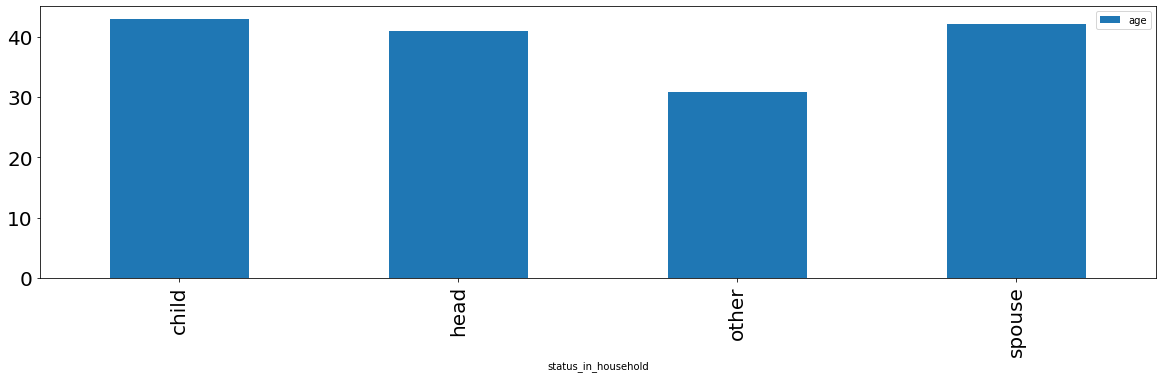

In [23]:
# Analyzing status_in_household per age
data[['status_in_household',
      'age']].groupby('status_in_household').mean().plot(kind='bar',
                                                         figsize=(20, 5),
                                                         fontsize=20)


### Annual Income


Text(0, 0.5, 'household_annual_income')

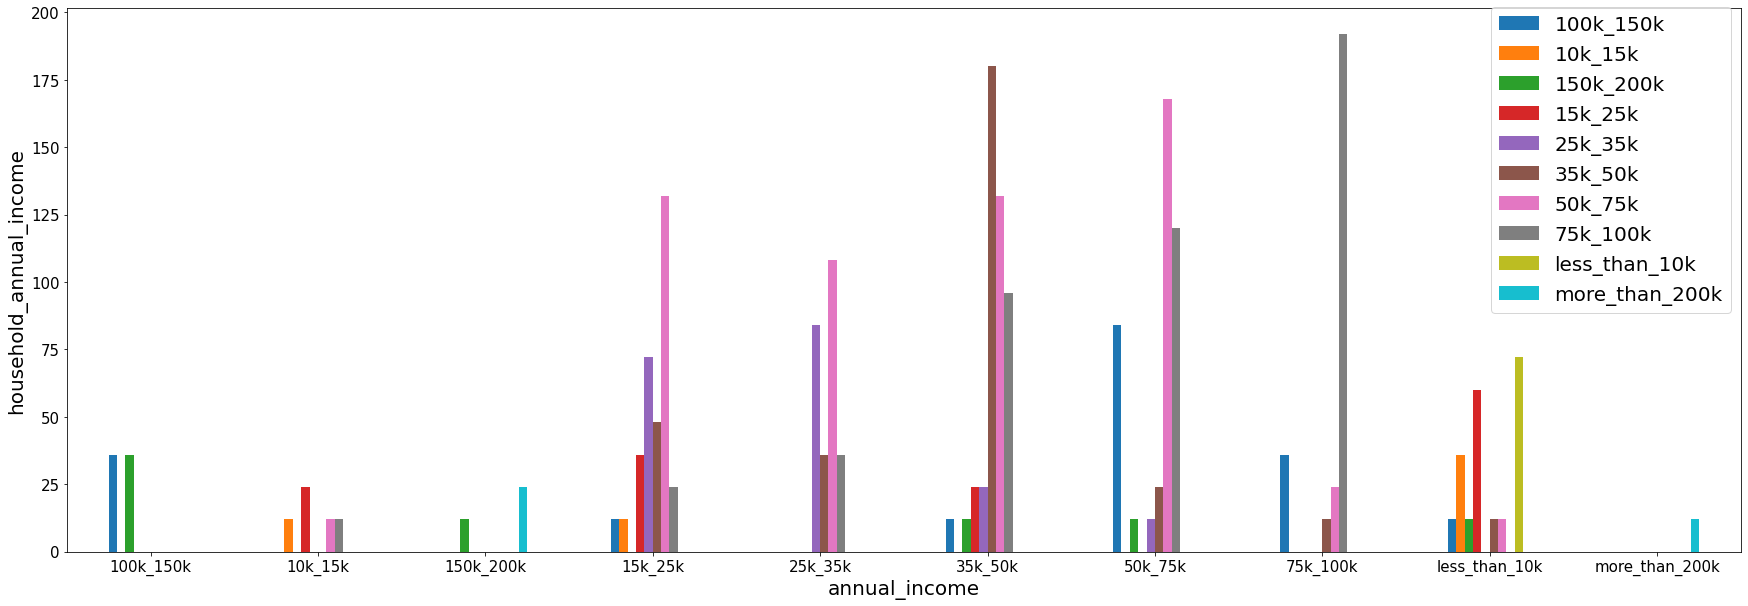

In [24]:
# Analyzing annual_income against household_annual_income
income = pd.crosstab(data['annual_income'], data['household_annual_income'])

a = income.plot(kind='bar', rot=0, figsize=(30, 10), fontsize=15)
a.legend(bbox_to_anchor=(1, 1.02), loc='best', fontsize=20)
a.set_xlabel('annual_income', fontsize=20)
a.set_ylabel('household_annual_income', fontsize=20)

### household_type vs. children_home


Text(0, 0.5, 'children_home')

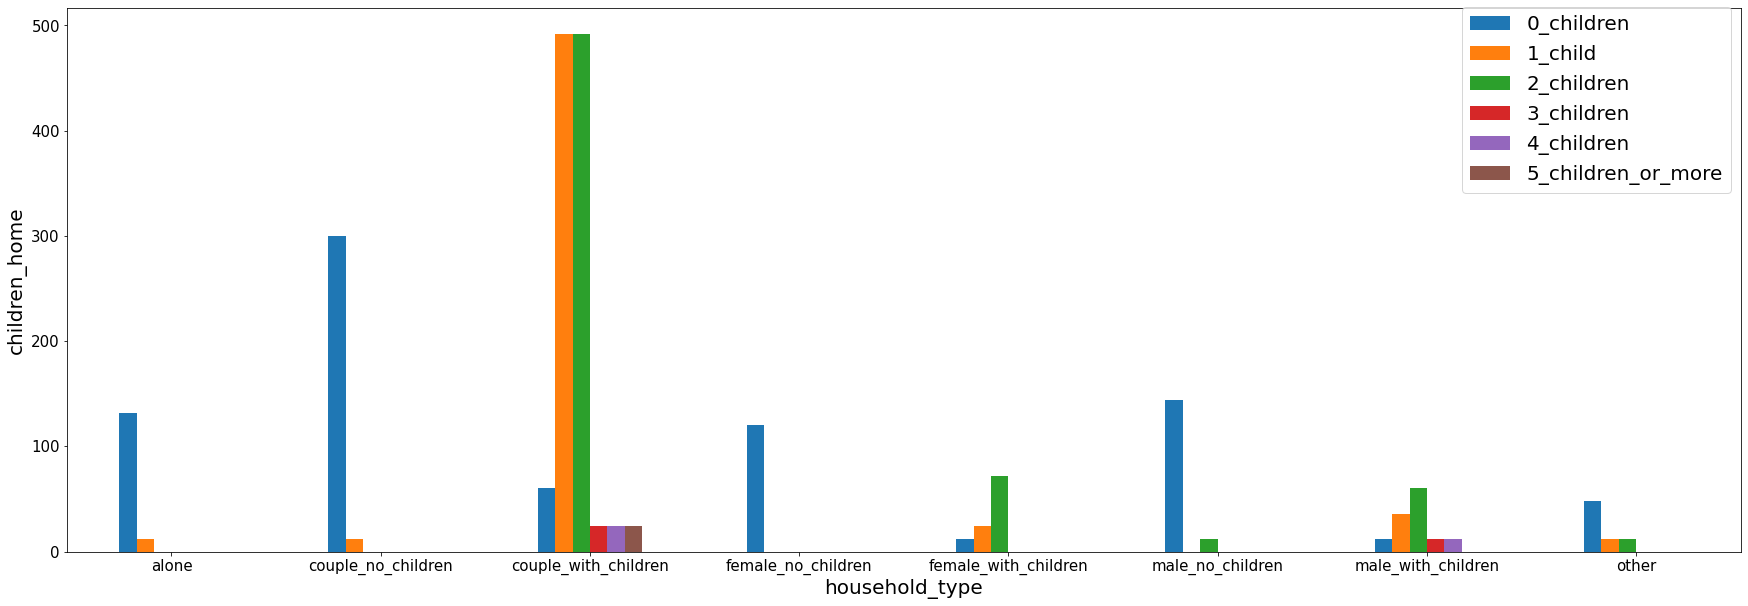

In [25]:
# Analyzing household_type against children_home
children_home = pd.crosstab(data['household_type'], data['children_home'])

a = children_home.plot(kind='bar', rot=0, figsize=(30, 10), fontsize=15)
a.legend(bbox_to_anchor=(1, 1.02), loc='best', fontsize=20)
a.set_xlabel('household_type', fontsize=20)
a.set_ylabel('children_home', fontsize=20)

## Removing akward outliers


In [26]:
data_filtered = data.copy()
print("Shape before filtering: ", data_filtered.shape)

# Removing rows where house_annual_income is lower than annual_income
data_filtered = data_filtered.drop(data_filtered[
    (data_filtered['annual_income'] == '10k_15k')
    & (data_filtered['household_annual_income'] == 'less_than_10k')].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['annual_income'] == '15k_25k') & (
        (data_filtered['household_annual_income'] == 'less_than_10k')
        | (data_filtered['household_annual_income'] == '10k_15k'))].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['annual_income'] == '25k_35k') & (
        (data_filtered['household_annual_income'] == 'less_than_10k')
        | (data_filtered['household_annual_income'] == '10k_15k')
        | (data_filtered['household_annual_income'] == '15k_25k'))].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['annual_income'] == '35k_50k') & (
        (data_filtered['household_annual_income'] == 'less_than_10k')
        | (data_filtered['household_annual_income'] == '10k_15k')
        | (data_filtered['household_annual_income'] == '15k_25k')
        | (data_filtered['household_annual_income'] == '25k_35k'))].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['annual_income'] == '50k_75k') & (
        (data_filtered['household_annual_income'] == 'less_than_10k')
        | (data_filtered['household_annual_income'] == '10k_15k')
        | (data_filtered['household_annual_income'] == '15k_25k')
        | (data_filtered['household_annual_income'] == '25k_35k')
        | (data_filtered['household_annual_income'] == '35k_50k'))].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['annual_income'] == '75k_100k') & (
        (data_filtered['household_annual_income'] == 'less_than_10k')
        | (data_filtered['household_annual_income'] == '10k_15k')
        | (data_filtered['household_annual_income'] == '15k_25k')
        | (data_filtered['household_annual_income'] == '25k_35k')
        | (data_filtered['household_annual_income'] == '35k_50k')
        | (data_filtered['household_annual_income'] == '50k_75k'))].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['annual_income'] == '100k_150k') & (
        (data_filtered['household_annual_income'] == 'less_than_10k')
        | (data_filtered['household_annual_income'] == '10k_15k')
        | (data_filtered['household_annual_income'] == '15k_25k')
        | (data_filtered['household_annual_income'] == '25k_35k')
        | (data_filtered['household_annual_income'] == '35k_50k')
        | (data_filtered['household_annual_income'] == '50k_75k')
        | (data_filtered['household_annual_income'] == '75k_100k'))].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['annual_income'] == 'i_150k_200k') & (
        (data_filtered['household_annual_income'] == 'a_less_than_10k')
        | (data_filtered['household_annual_income'] == 'b_10k_15k')
        | (data_filtered['household_annual_income'] == 'c_15k_25k')
        | (data_filtered['household_annual_income'] == 'd_25k_35k')
        | (data_filtered['household_annual_income'] == 'e_35k_50k')
        | (data_filtered['household_annual_income'] == 'f_50k_75k')
        | (data_filtered['household_annual_income'] == 'g_75k_100k')
        | (data_filtered['household_annual_income'] == 'h_100k_150k'))].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['annual_income'] == 'j_more_than_200k') & (
        (data_filtered['household_annual_income'] == 'a_less_than_10k')
        | (data_filtered['household_annual_income'] == 'b_10k_15k')
        | (data_filtered['household_annual_income'] == 'c_15k_25k')
        | (data_filtered['household_annual_income'] == 'd_25k_35k')
        | (data_filtered['household_annual_income'] == 'e_35k_50k')
        | (data_filtered['household_annual_income'] == 'f_50k_75k')
        | (data_filtered['household_annual_income'] == 'g_75k_100k')
        | (data_filtered['household_annual_income'] == 'h_100k_150k')
        | (data_filtered['household_annual_income'] == 'i_150k_200k'))].index)

# Removing rows where household_type and children_home do not coincide
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['household_type'] == '0_alone') & (
        (data_filtered['children_home'] == '1_child')
        | (data_filtered['children_home'] == '2_children')
        | (data_filtered['children_home'] == '3_children')
        | (data_filtered['children_home'] == '4_children')
        | (data_filtered['children_home'] == '5_children_or_more'))].index)

data_filtered = data_filtered.drop(data_filtered[
    (data_filtered['household_type'] == '0_couple_no_children')
    & ((data_filtered['children_home'] == '1_child')
       | (data_filtered['children_home'] == '2_children')
       | (data_filtered['children_home'] == '3_children')
       | (data_filtered['children_home'] == '4_children')
       | (data_filtered['children_home'] == '5_children_or_more'))].index)
data_filtered = data_filtered.drop(data_filtered[
    (data_filtered['household_type'] == '0_female_no_children')
    & ((data_filtered['children_home'] == '1_child')
       | (data_filtered['children_home'] == '2_children')
       | (data_filtered['children_home'] == '3_children')
       | (data_filtered['children_home'] == '4_children')
       | (data_filtered['children_home'] == '5_children_or_more'))].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['household_type'] == '0_male_no_children') & (
        (data_filtered['children_home'] == '1_child')
        | (data_filtered['children_home'] == '2_children')
        | (data_filtered['children_home'] == '3_children')
        | (data_filtered['children_home'] == '4_children')
        | (data_filtered['children_home'] == '5_children_or_more'))].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['household_type'] == '1_couple_with_children')
                  & (data_filtered['children_home'] == '0_children')].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['household_type'] == '1_female_children')
                  & (data_filtered['children_home'] == '0_children')].index)
data_filtered = data_filtered.drop(
    data_filtered[(data_filtered['household_type'] == '1_male_children')
                  & (data_filtered['children_home'] == '0_children')].index)

# status_in_household to be excluded in the model

print("Shape after filtering: ", data_filtered.shape)


Shape before filtering:  (2160, 44)
Shape after filtering:  (2028, 44)


In [27]:
data_filtered.describe()

age  average_probability_fatality  \
count  2028.000000                   2028.000000   
mean     40.863905                      4.008054   
std      12.191824                      1.782534   
min      21.000000                      0.500000   
25%      31.000000                      2.833333   
50%      37.000000                      5.166667   
75%      51.000000                      5.166667   
max      72.000000                      7.500000   

       delta_probability_fatality_orbital  \
count                         2028.000000   
mean                            -0.016108   
std                              2.694918   
min                             -4.666667   
25%                             -2.333333   
50%                              0.000000   
75%                              2.333333   
max                              4.666667   

       delta_probability_fatality_suborbital  \
count                            2028.000000   
mean                                0.008054   
std                                 3.385400   
min                                -4.666667   
25%                                -2.333333   
50%                                 0.000000   
75%                                 2.333333   
max                                 4.666667   

       delta_probability_fatality_moon_trip  average_price_dollars  \
count                           2028.000000            2028.000000   
mean                               0.008054           65352.422337   
std                                2.917490           74740.405610   
min                               -4.666667             150.000000   
25%                               -2.333333           14591.666667   
50%                                0.000000           42466.666667   
75%                                2.333333           86562.500000   
max                                4.666667          906250.000000   

       delta_price_dollars_orbital  delta_price_dollars_suborbital  \
count                  2028.000000                     2028.000000   
mean                    460.392012                     -230.196006   
std                   70804.388363                    79533.631825   
min                 -520833.333333                  -599166.666667   
25%                  -20970.833333                   -20970.833333   
50%                    -391.666667                     4700.000000   
75%                   35950.000000                    37612.500000   
max                  419416.666667                   419416.666667   

       delta_price_dollars_moon_trip  
count                    2028.000000  
mean                     -230.196006  
std                     82803.268184  
min                   -599166.666667  
25%                    -20970.833333  
50%                         0.000000  
75%                     36458.333333  
max                    599166.666667

Text(0, 0.5, 'household_annual_income')

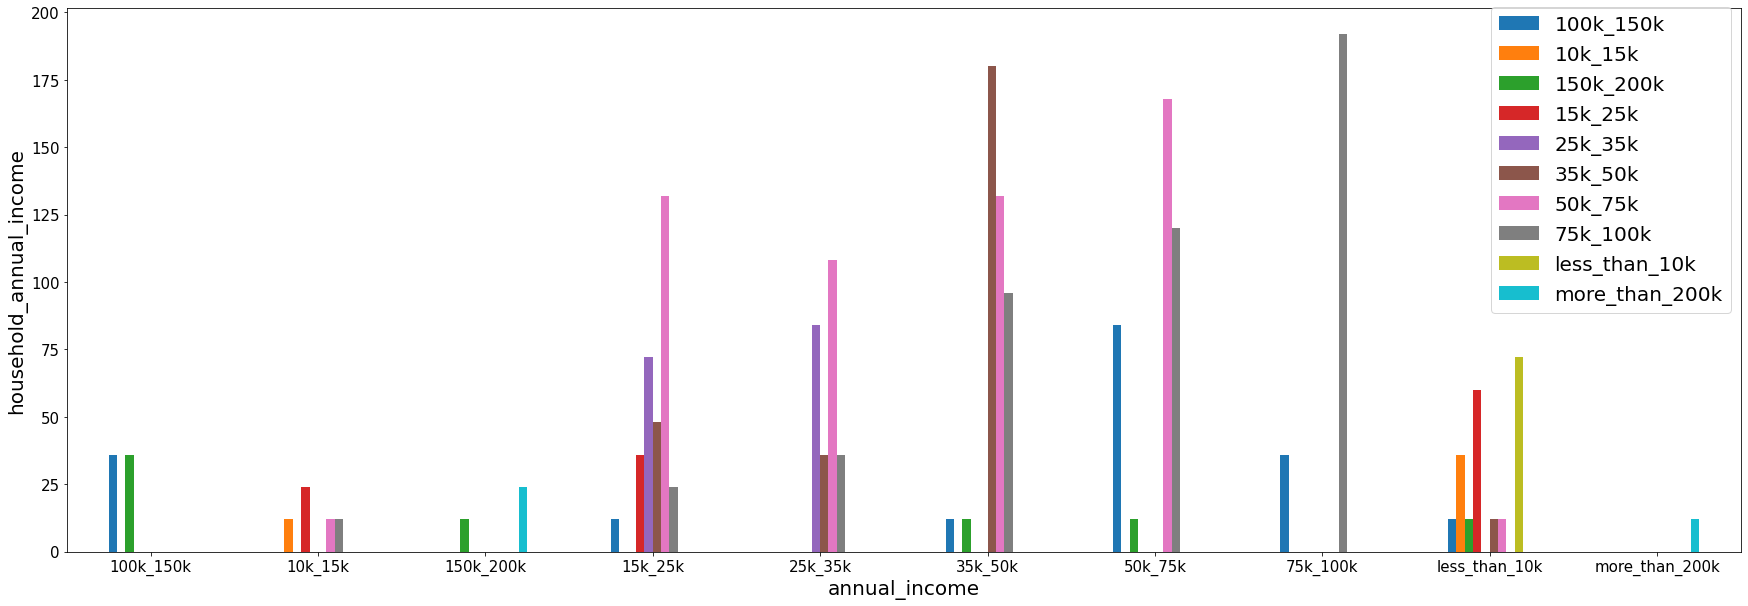

In [28]:
# Analyzing annual_income against household_annual_income after filtering

income_2 = pd.crosstab(data_filtered['annual_income'],
                       data_filtered['household_annual_income'])

a = income_2.plot(kind='bar', rot=0, figsize=(30, 10), fontsize=15)
a.legend(bbox_to_anchor=(1, 1.02), loc='best', fontsize=20)
a.set_xlabel('annual_income', fontsize=20)
a.set_ylabel('household_annual_income', fontsize=20)

Text(0, 0.5, 'children_home')

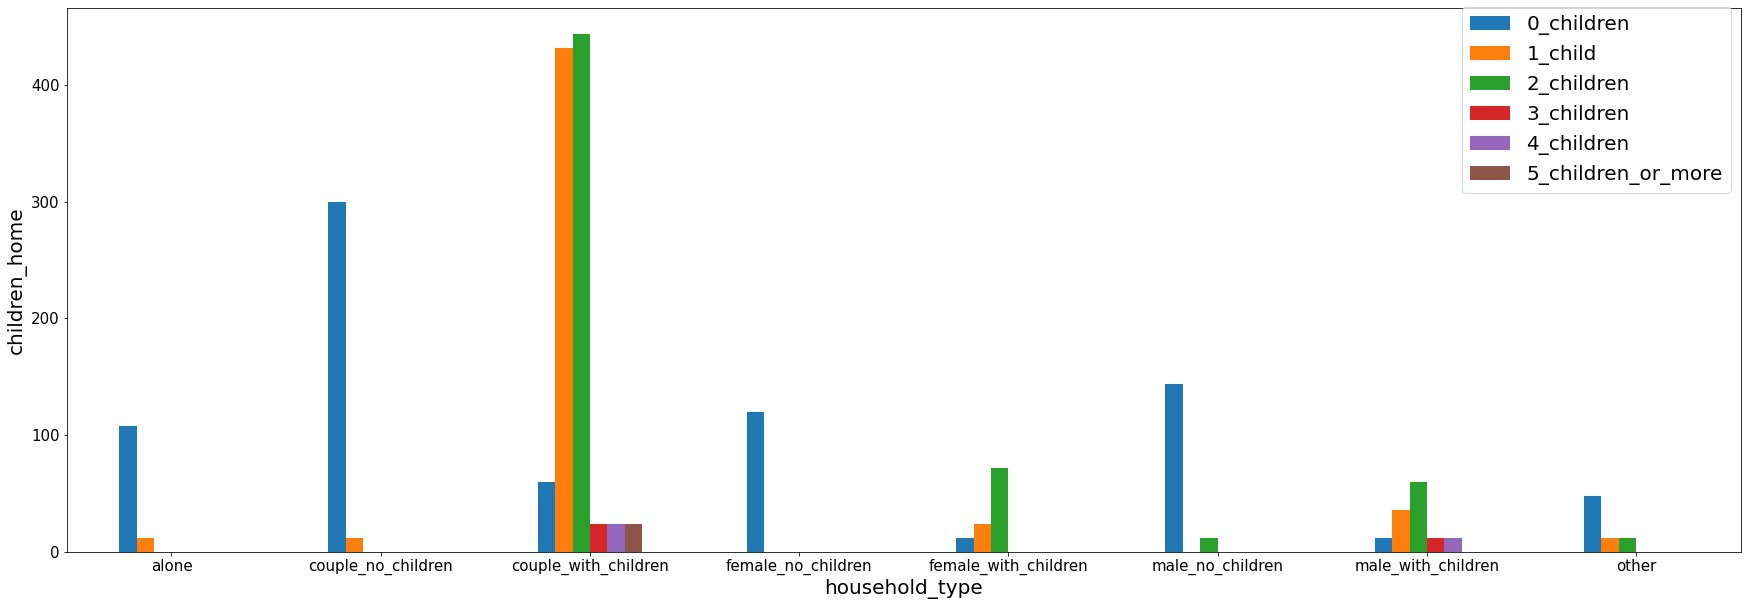

In [29]:
# Analyzing household_type against children_home after filtering
children_home_2 = pd.crosstab(data_filtered['household_type'],
                              data_filtered['children_home'])

a = children_home_2.plot(kind='bar', rot=0, figsize=(30, 10), fontsize=15)
a.legend(bbox_to_anchor=(1, 1.02), loc='best', fontsize=20)
a.set_xlabel('household_type', fontsize=20)
a.set_ylabel('children_home', fontsize=20)

## Statistics final dataset


In [30]:
profile = ProfileReport(data_filtered, title='Report')
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
profile.to_file(base_dir +
                'data/modelingData_SpaceTourism_strings_v4_Report.html')


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Saving processed data


In [32]:
data_filtered.to_csv(base_dir +
                     'data/modelingData_SpaceTourism_strings_v4.csv',
                     index=False)


# 2. Modeling


In [33]:
data = pd.read_csv(base_dir + 'data/modelingData_SpaceTourism_strings_v4.csv')
data.shape

(2028, 44)

In [34]:
# TABLE WITH DESCRIPTIVE STATISTICS

# Numerical features
statistics_numeric = data.describe().transpose().reset_index()
statistics_numeric.rename(columns={'50%': 'median'}, inplace=True)
statistics_numeric['statistics'] = 'mean: ' + round(
    statistics_numeric['mean'], 2).astype(str) + ', median: ' + round(
        statistics_numeric['median'], 2).astype(str) + ', min: ' + round(
            statistics_numeric['min'], 2).astype(str) + ', max: ' + round(
                statistics_numeric['max'], 2).astype(str)

# Categorical features
statistics_categorical = data.describe(include='O').transpose().reset_index()
statistics_categorical['statistics'] = statistics_categorical['index'].apply(
    lambda x: ', '.join(data[x].value_counts().reset_index()[
        'index'] + ': ' + round(data[x].value_counts(normalize=True) * 100, 1).
                        astype(str).reset_index()[x] + '%'))

# Concatenating both numeric and categorical features
statistics = pd.concat([statistics_categorical, statistics_numeric], axis=0)
statistics[['index', 'unique',
            'statistics']].to_csv(base_dir + 'data/descriptive_statistics.csv',
                                  index=False)
statistics[['index', 'unique', 'statistics']]

index unique  \
0                                  choice      4   
1                                  gender      2   
2                           annual_income     10   
3                 household_annual_income     10   
4                         number_vehicles      4   
5                         level_education      5   
6                               work_type      4   
7                           children_home      6   
8                          household_type      8   
9                     status_in_household      4   
10                         type_residence      3   
11                    housing_tenure_type      2   
12                                 origin      2   
13                                   race      5   
14                            citizenship      2   
15                 risk_activities_sports      3   
16             price_attribute_suborbital      3   
17                availability_suborbital      2   
18                    training_suborbital      2   
19           number_passengers_suborbital      2   
20            takeoff_location_suborbital      2   
21                price_attribute_orbital      3   
22                   availability_orbital      2   
23                       training_orbital      2   
24              number_passengers_orbital      2   
25               takeoff_location_orbital      2   
26              price_attribute_moon_trip      3   
27                 availability_moon_trip      2   
28                     training_moon_trip      2   
29            number_passengers_moon_trip      2   
30             takeoff_location_moon_trip      2   
31                         generation_age      4   
32                                   city    128   
33                                  state     30   
34                                 region      4   
0                                     age    NaN   
1            average_probability_fatality    NaN   
2      delta_probability_fatality_orbital    NaN   
3   delta_probability_fatality_suborbital    NaN   
4    delta_probability_fatality_moon_trip    NaN   
5                   average_price_dollars    NaN   
6             delta_price_dollars_orbital    NaN   
7          delta_price_dollars_suborbital    NaN   
8           delta_price_dollars_moon_trip    NaN   

                                           statistics  
0   suborbital: 28.1%, moon_trip: 26.9%, not_trave...  
1                          male: 59.2%, female: 40.8%  
2   35k_50k: 21.3%, 50k_75k: 18.9%, 15k_25k: 16.0%...  
3   50k_75k: 27.8%, 75k_100k: 23.7%, 35k_50k: 13.6...  
4   2_cars: 52.7%, 1_car: 36.1%, 3_cars: 6.5%, 4_o...  
5   bachelor_degree: 62.7%, grad_prof_degree: 14.8...  
6   private: 73.4%, self_employed: 18.9%, governme...  
7   0_children: 39.6%, 2_children: 29.6%, 1_child:...  
8   couple_with_children: 49.7%, couple_no_childre...  
9   head: 59.8%, spouse: 30.8%, child: 4.7%, other...  
10        house: 77.5%, apartment: 21.9%, other: 0.6%  
11                            own: 75.1%, rent: 24.9%  
12               non_hispanic: 81.7%, hispanic: 18.3%  
13  white: 82.2%, asian: 7.1%, black: 5.3%, two_or...  
14                     us_citizen: 97.6%, other: 2.4%  
15          rarely: 44.4%, never: 35.5%, often: 20.1%  
16  362_perc_annual_income: 33.3%, 50_perc_annual_...  
17                immediate: 50.0%, in_5_years: 50.0%  
18                              no: 50.0%, yes: 50.0%  
19                   one: 50.3%, more_than_one: 49.7%  
20                           usa: 50.3%, other: 49.7%  
21  362_perc_annual_income: 33.7%, 3_perc_annual_i...  
22                immediate: 50.0%, in_5_years: 50.0%  
23                              yes: 50.0%, no: 50.0%  
24                   one: 50.0%, more_than_one: 50.0%  
25                           usa: 50.0%, other: 50.0%  
26  3_perc_annual_income: 33.3%, 362_perc_annual_i...  
27                immediate: 50.0%, in_5_years: 50.0%  
28                              no: 50.0%, yes: 50.0%  
29             

In [35]:
# Looking different levels of categorical features

for i in data[[
        'number_vehicles', 'level_education', 'children_home',
        'risk_activities_sports', 'generation_age'
]].columns:
    print(i, '\n', data[i].value_counts(normalize=True))
    print('---------------------------------\n')

number_vehicles 
 2_cars            0.526627
1_car             0.360947
3_cars            0.065089
4_or_more_cars    0.047337
Name: number_vehicles, dtype: float64
---------------------------------

level_education 
 bachelor_degree         0.627219
grad_prof_degree        0.147929
some_college            0.124260
high_school_graduate    0.065089
associate_degree        0.035503
Name: level_education, dtype: float64
---------------------------------

children_home 
 0_children            0.396450
2_children            0.295858
1_child               0.260355
4_children            0.017751
3_children            0.017751
5_children_or_more    0.011834
Name: children_home, dtype: float64
---------------------------------

risk_activities_sports 
 rarely    0.443787
never     0.355030
often     0.201183
Name: risk_activities_sports, dtype: float64
---------------------------------

generation_age 
 millenials      0.538462
gen_x           0.230769
centennials     0.136095
baby_boomers    0.

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2028 entries, 0 to 2027
Data columns (total 44 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   choice                                 2028 non-null   object 
 1   gender                                 2028 non-null   object 
 2   annual_income                          2028 non-null   object 
 3   household_annual_income                2028 non-null   object 
 4   number_vehicles                        2028 non-null   object 
 5   level_education                        2028 non-null   object 
 6   work_type                              2028 non-null   object 
 7   children_home                          2028 non-null   object 
 8   household_type                         2028 non-null   object 
 9   status_in_household                    2028 non-null   object 
 10  type_residence                         2028 non-null   object 
 11  hous

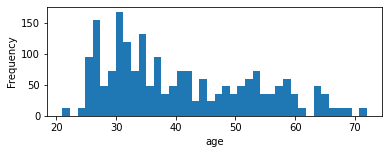

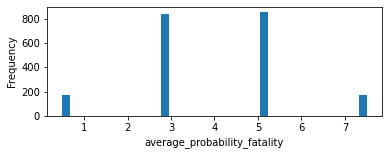

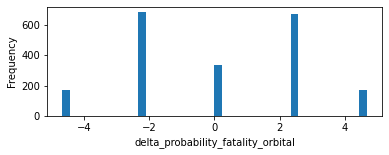

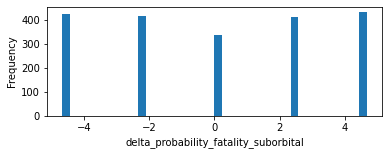

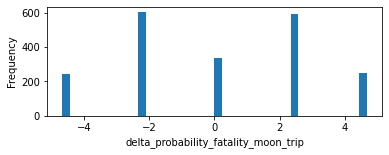

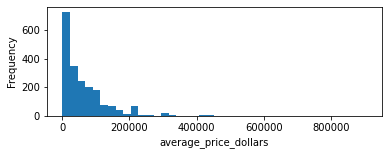

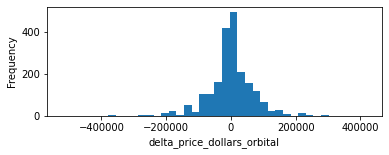

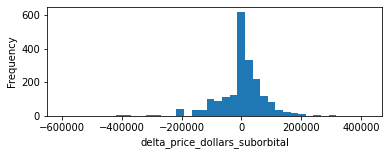

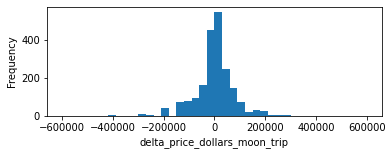

In [37]:
# Creating a histogram for each numerical feature
num_feat = data.select_dtypes(include=['int64', 'float64']).columns

for i in data[num_feat].columns:
    plt.figure(figsize=(6, 2))
    plt.hist(data[i], bins=40)

    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.savefig(base_dir + 'images/distributions/' + i + '.png')
    plt.show()

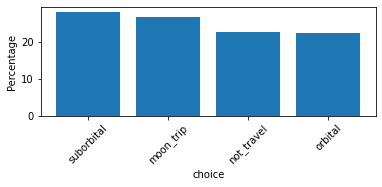

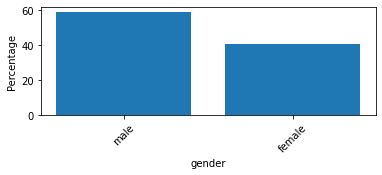

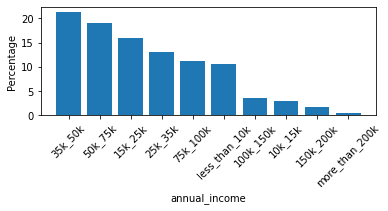

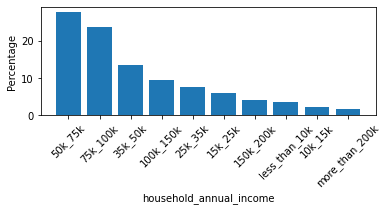

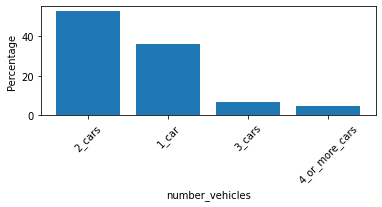

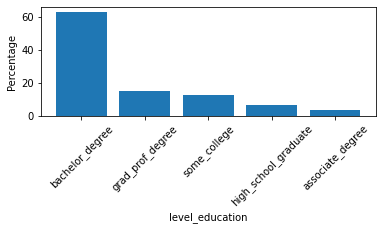

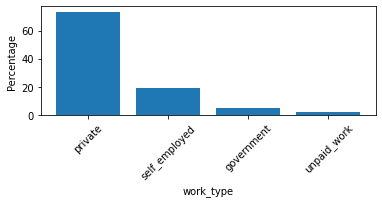

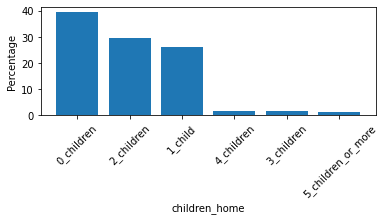

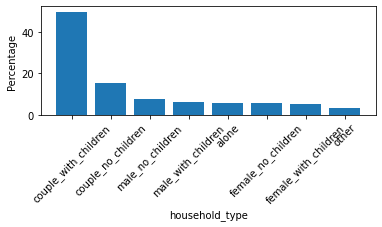

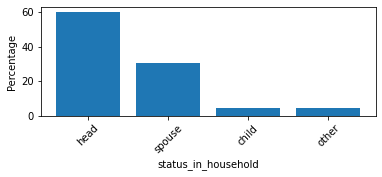

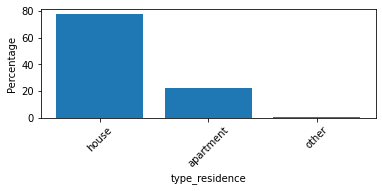

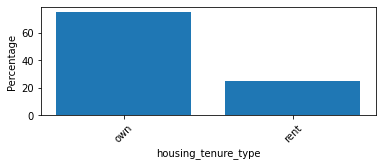

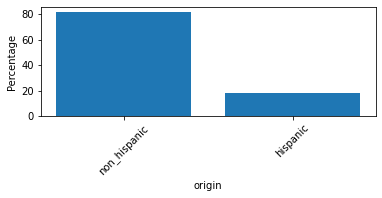

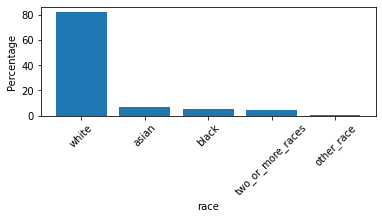

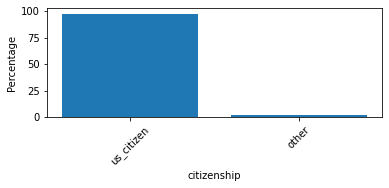

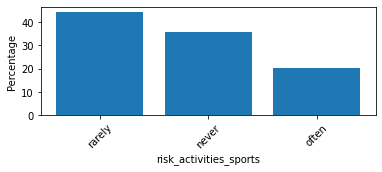

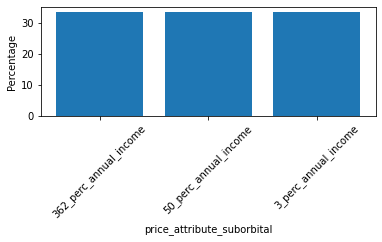

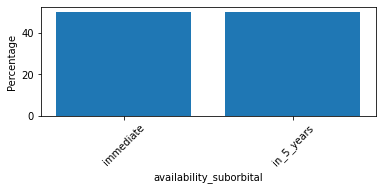

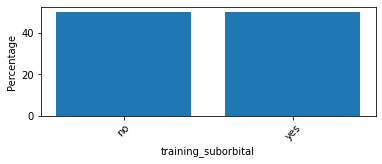

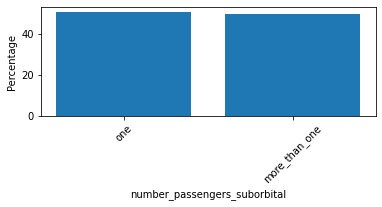

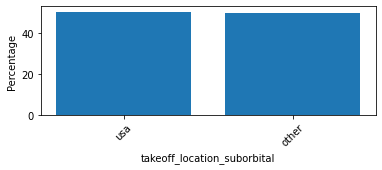

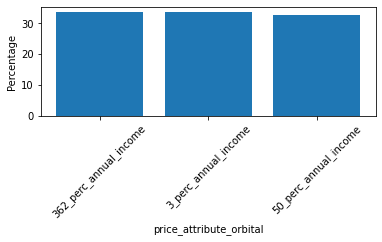

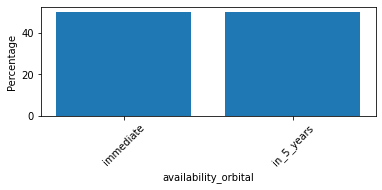

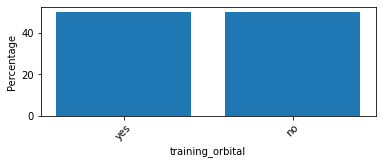

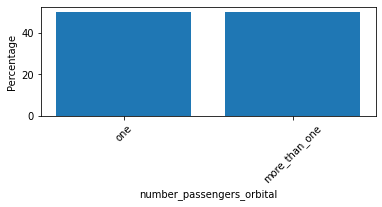

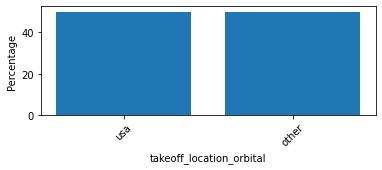

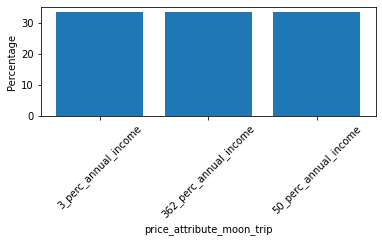

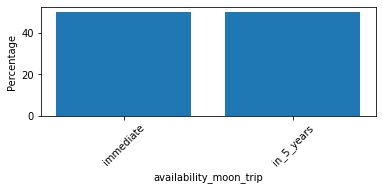

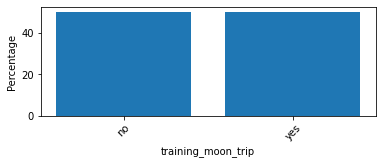

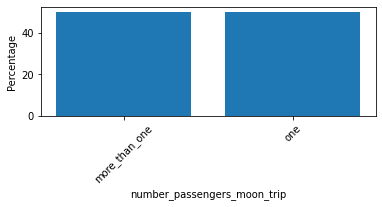

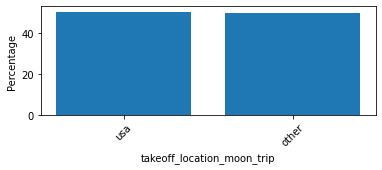

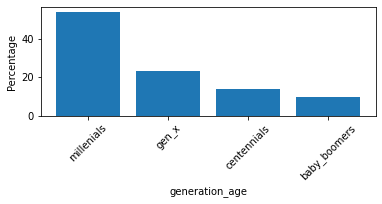

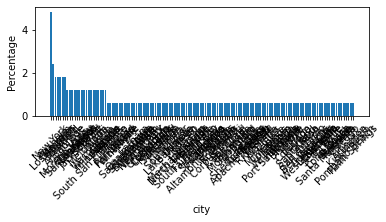

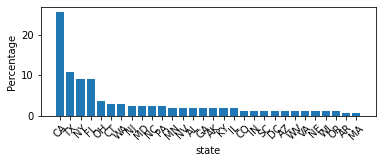

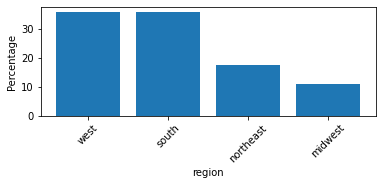

In [38]:
cat_feat = data.select_dtypes(include=['object']).columns

# Creating a bar plot for each categorical feature, y-axis in percentage. Values shown alphabetically
for i in data[cat_feat].columns:
    plt.figure(figsize=(6, 2))
    plt.bar(data[i].value_counts().index,
            data[i].value_counts(normalize=True) * 100)
    plt.xlabel(i)
    plt.xticks(rotation=45)
    plt.ylabel('Percentage')
    plt.savefig(base_dir + 'images/distributions/' + i + '.png')
    plt.show()


In [41]:
from pycaret.classification import *

exp1 = setup(
    data=data,
    target='choice',
    session_id=42,
    normalize=True,
    #normalize_method='minmax',
    #transformation=True,
    #pca = True,
    ignore_features=['city', 'state', 'generation_age', 'status_in_household'],
    ordinal_features={
        # 'annual_income': [
        #     'a_less_than_10k', 'b_10k_15k', 'c_15k_25k', 'd_25k_35k',
        #     'e_35k_50k', 'f_50k_75k', 'g_75k_100k', 'h_100k_150k',
        #     'i_150k_200k', 'j_more_than_200k'
        # ],
        # 'household_annual_income': [
        #     'a_less_than_10k', 'b_10k_15k', 'c_15k_25k', 'd_25k_35k',
        #     'e_35k_50k', 'f_50k_75k', 'g_75k_100k', 'h_100k_150k',
        #     'i_150k_200k', 'j_more_than_200k'
        # ],
        'number_vehicles': ['1_car', '2_cars', '3_cars', '4_or_more_cars'],
        'level_education': [
            # 'less_9th_grade', '9th_12th_grade_nodiploma', # Nobody in those ranges
            'high_school_graduate',
            'some_college',
            'associate_degree',
            'bachelor_degree',
            'grad_prof_degree'
        ],
        'children_home': [
            '0_children', '1_child', '2_children', '3_children', '4_children',
            '5_children_or_more'
        ],
        'risk_activities_sports': ['never', 'rarely', 'often'],
        # 'generation_age':
        # ['baby_boomers', 'gen_x', 'millenials', 'centennials']
    },
    train_size=0.8,
    use_gpu=True,
    combine_rare_levels=True,  # Added
    remove_multicollinearity=True,  # Added
    unknown_categorical_method='most_frequent',  # Added
    remove_outliers=True,  # Added
    fix_imbalance=True,
    data_split_stratify=True,
    fold_strategy='stratifiedkfold',
    silent=True,
    log_experiment=True,
    experiment_name='first_exp',
)


In [42]:
best_models = compare_models(
    turbo=False,
    sort='auc',
    round=3,
    include=[
        'lr', 'dt', 'et', 'rf', 'lightgbm'
    ]  # This line is included to present the results of just 5 models included in the paper.
)


## lightGBM


In [43]:
# Best ML analysis
lightgbm = create_model(estimator='lightgbm', fit_kwargs={'verbose': -1})


In [44]:
# Prediciendo en el data set de testeo
test_holdout_set = predict_model(estimator=lightgbm)
test_holdout_set.head()


number_vehicles  level_education  children_home  risk_activities_sports  \
0              1.0              3.0            2.0                     2.0   
1              1.0              3.0            0.0                     1.0   
2              1.0              3.0            0.0                     1.0   
3              1.0              4.0            2.0                     1.0   
4              2.0              4.0            5.0                     0.0   

        age  average_probability_fatality  delta_probability_fatality_orbital  \
0 -0.014497                      0.663317                           -0.867227   
1 -1.157581                     -0.642387                            0.865091   
2 -0.096146                      0.663317                           -0.867227   
3 -0.586039                     -1.948091                           -0.001068   
4  0.067151                      0.663317                           -0.867227   

   delta_probability_fatality_suborbital  \
0                               1.377970   
1                               0.689197   
2                               1.377970   
3                               0.000425   
4                               1.377970   

   delta_probability_fatality_moon_trip  average_price_dollars  ...  \
0                             -0.802900              -0.550552  ...   
1                             -1.606295              -0.673776  ...   
2                             -0.802900              -0.673776  ...   
3                              0.000495              -0.550552  ...   
4                             -0.802900              -0.282655  ...   

   number_passengers_moon_trip_more_than_one  takeoff_location_moon_trip_usa  \
0                                        1.0                             1.0   
1                                        0.0                             0.0   
2                                        0.0                             1.0   
3                                        1.0                             0.0   
4                                        0.0                             1.0   

   region_midwest  region_northeast  region_not_available  region_south  \
0             0.0               0.0                   0.0           1.0   
1             0.0               0.0                   0.0           0.0   
2             0.0               0.0                   0.0           1.0   
3             0.0               0.0                   0.0           0.0   
4             0.0               0.0                   0.0           1.0   

   region_west      choice       Label   Score  
0          0.0  suborbital     orbital  0.8168  
1          1.0  not_travel  not_travel  0.8830  
2          0.0  suborbital  suborbital  0.8734  
3          1.0   moon_trip  suborbital  0.5756  
4          0.0  not_travel  not_travel  0.9777  

[5 rows x 79 columns]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


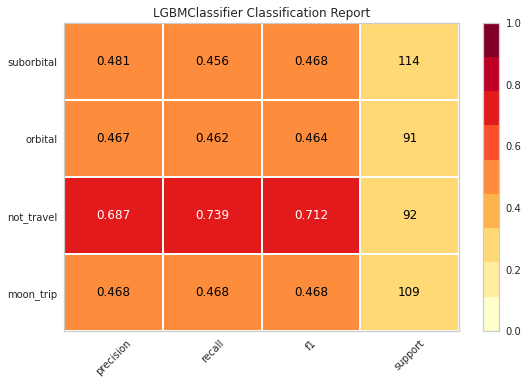

In [45]:
# Plotting the classification report
plot_model(estimator=lightgbm, plot='class_report', use_train_data=False)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


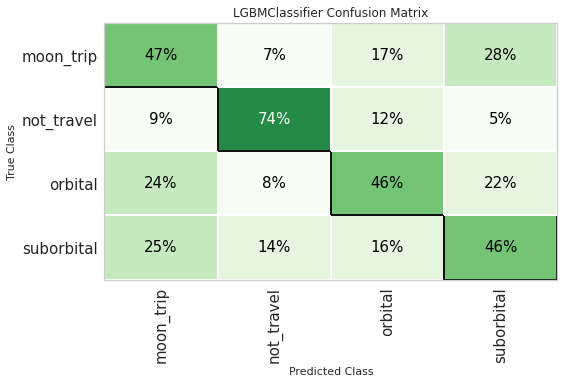

In [46]:
plot_model(lightgbm,
           plot='confusion_matrix',
           plot_kwargs={'percent': True},
           use_train_data=False)


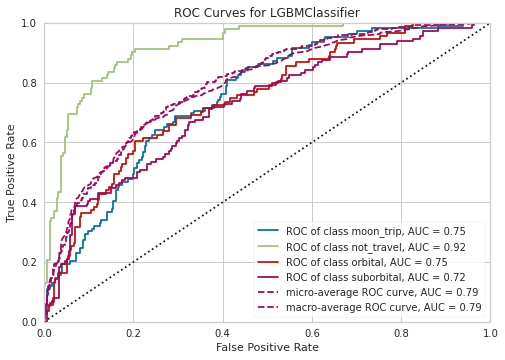

In [47]:
# Plotting the AUC
plot_model(estimator=lightgbm, plot='auc', use_train_data=False)


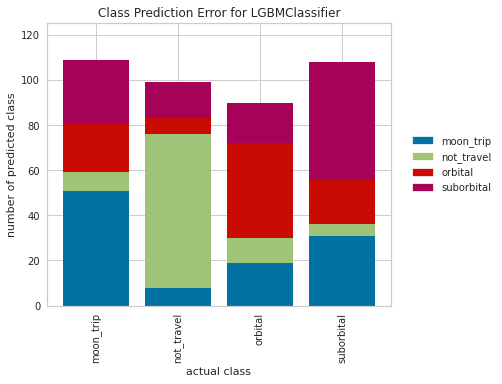

In [48]:
plot_model(estimator=lightgbm, plot='error')


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


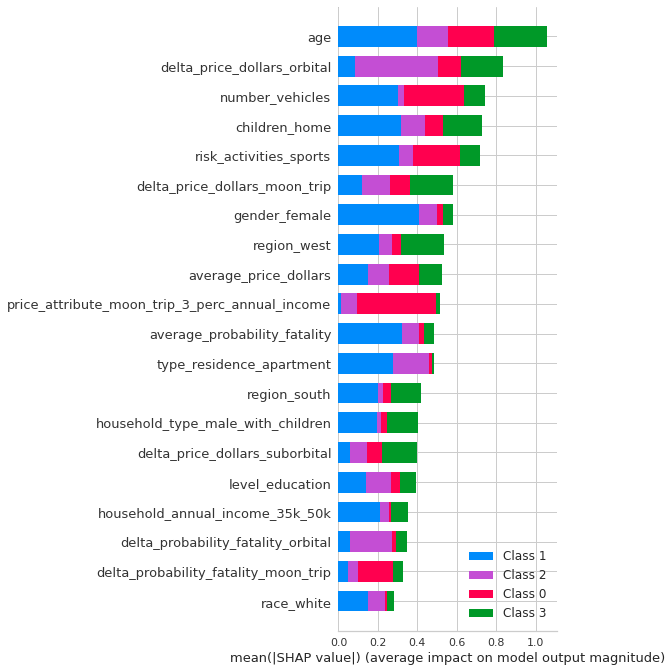

In [49]:
interpret_model(estimator=lightgbm)

# ValueError: type parameter only accepts 'summary', 'correlation', 'reason', 'pdp', 'msa' or 'pfi'.

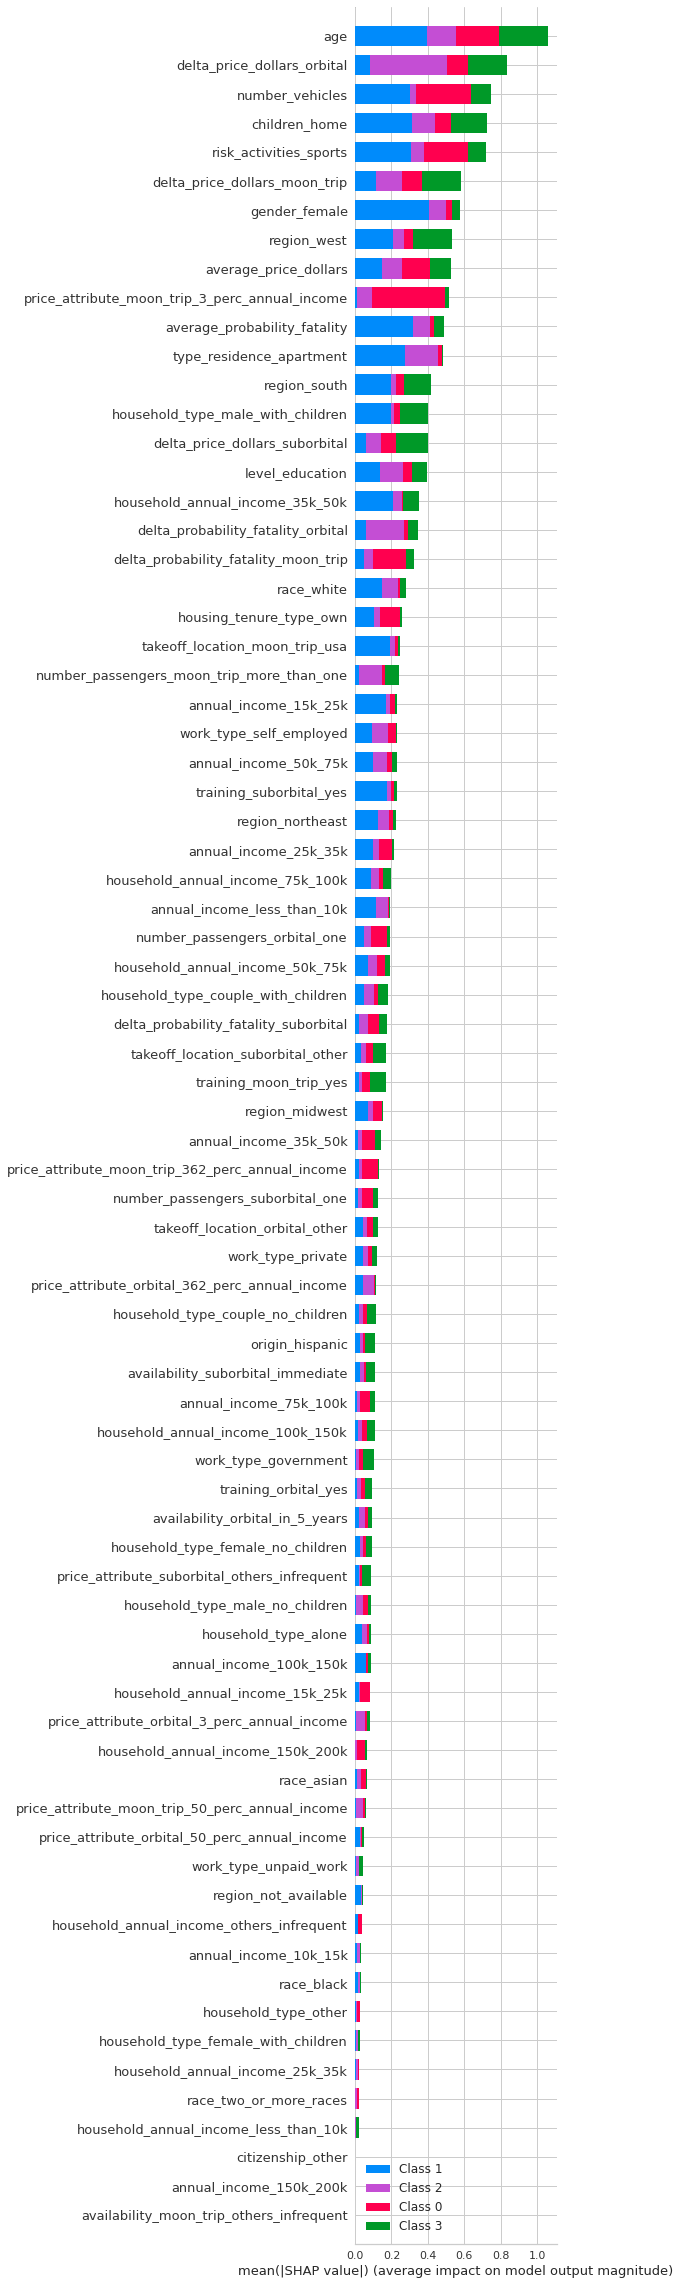

In [50]:
## Visualizing impact of ALL features

# shap TreeExplainer
X_test = get_config('X_test')
explainer = shap.TreeExplainer(lightgbm)
shap_values = explainer.shap_values(X_test)

# summary plot
shap.summary_plot(shap_values, X_test,
                  max_display=X_test.shape[1])  # 62 columns


### Keep in mind the label codes:

- moon_trip: 0,
- not_travel: 1,
- orbital: 2,
- suborbital: 3


## Tuned lightgbm


In [51]:
# tune hyperparameters to optimize AUC
tuned_lightgbm = tune_model(lightgbm,
                            optimize='AUC',
                            n_iter=80,
                            fit_kwargs={'verbose': -1},
                            early_stopping=True,
                            choose_better=True)


In [52]:
# Prediciendo en el data set de testeo
test_holdout_set = predict_model(estimator=tuned_lightgbm)
test_holdout_set.head()


number_vehicles  level_education  children_home  risk_activities_sports  \
0              1.0              3.0            2.0                     2.0   
1              1.0              3.0            0.0                     1.0   
2              1.0              3.0            0.0                     1.0   
3              1.0              4.0            2.0                     1.0   
4              2.0              4.0            5.0                     0.0   

        age  average_probability_fatality  delta_probability_fatality_orbital  \
0 -0.014497                      0.663317                           -0.867227   
1 -1.157581                     -0.642387                            0.865091   
2 -0.096146                      0.663317                           -0.867227   
3 -0.586039                     -1.948091                           -0.001068   
4  0.067151                      0.663317                           -0.867227   

   delta_probability_fatality_suborbital  \
0                               1.377970   
1                               0.689197   
2                               1.377970   
3                               0.000425   
4                               1.377970   

   delta_probability_fatality_moon_trip  average_price_dollars  ...  \
0                             -0.802900              -0.550552  ...   
1                             -1.606295              -0.673776  ...   
2                             -0.802900              -0.673776  ...   
3                              0.000495              -0.550552  ...   
4                             -0.802900              -0.282655  ...   

   number_passengers_moon_trip_more_than_one  takeoff_location_moon_trip_usa  \
0                                        1.0                             1.0   
1                                        0.0                             0.0   
2                                        0.0                             1.0   
3                                        1.0                             0.0   
4                                        0.0                             1.0   

   region_midwest  region_northeast  region_not_available  region_south  \
0             0.0               0.0                   0.0           1.0   
1             0.0               0.0                   0.0           0.0   
2             0.0               0.0                   0.0           1.0   
3             0.0               0.0                   0.0           0.0   
4             0.0               0.0                   0.0           1.0   

   region_west      choice       Label   Score  
0          0.0  suborbital     orbital  0.7290  
1          1.0  not_travel  not_travel  0.4295  
2          0.0  suborbital  suborbital  0.4201  
3          1.0   moon_trip     orbital  0.4723  
4          0.0  not_travel  not_travel  0.9197  

[5 rows x 79 columns]

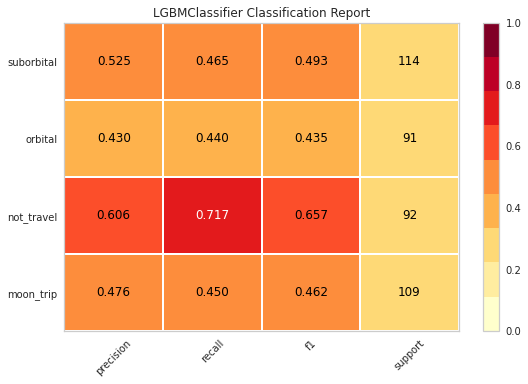

In [53]:
# Plotting the classification report
plot_model(estimator=tuned_lightgbm, plot='class_report', use_train_data=False)


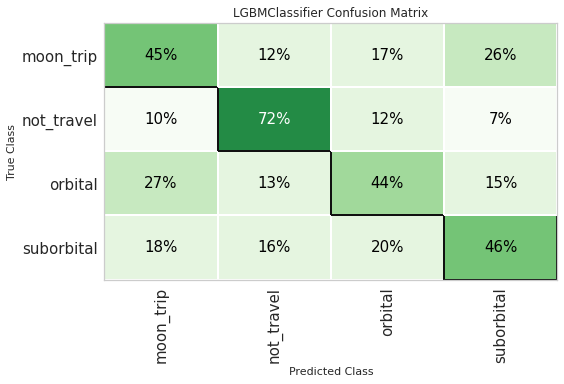

In [54]:
plot_model(tuned_lightgbm,
           plot='confusion_matrix',
           plot_kwargs={'percent': True},
           use_train_data=False)


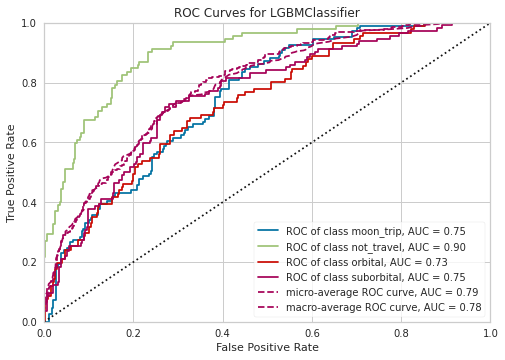

In [55]:
# Plotting the AUC
plot_model(estimator=tuned_lightgbm, plot='auc', use_train_data=False)


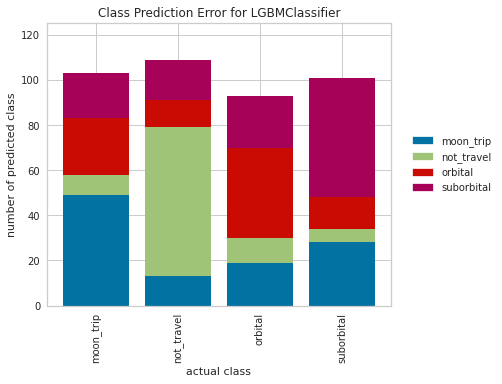

In [56]:
plot_model(estimator=tuned_lightgbm, plot='error')


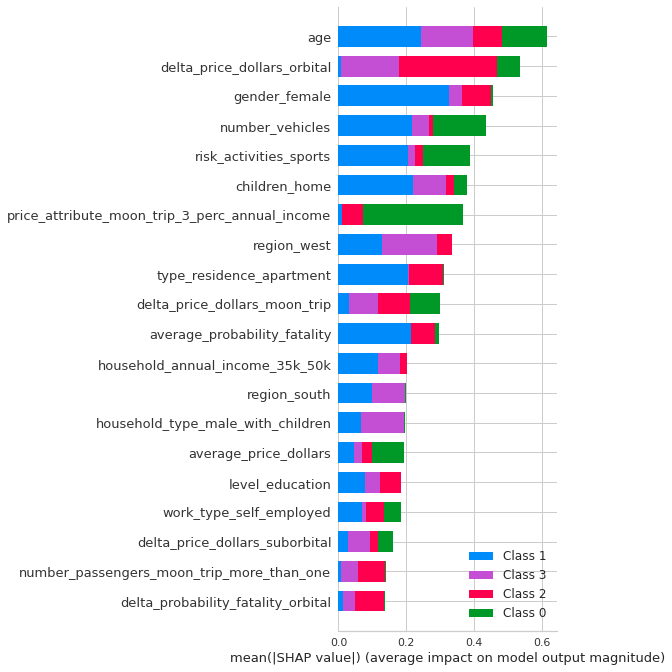

In [57]:
interpret_model(estimator=tuned_lightgbm)

# ValueError: type parameter only accepts 'summary', 'correlation', 'reason', 'pdp', 'msa' or 'pfi'.

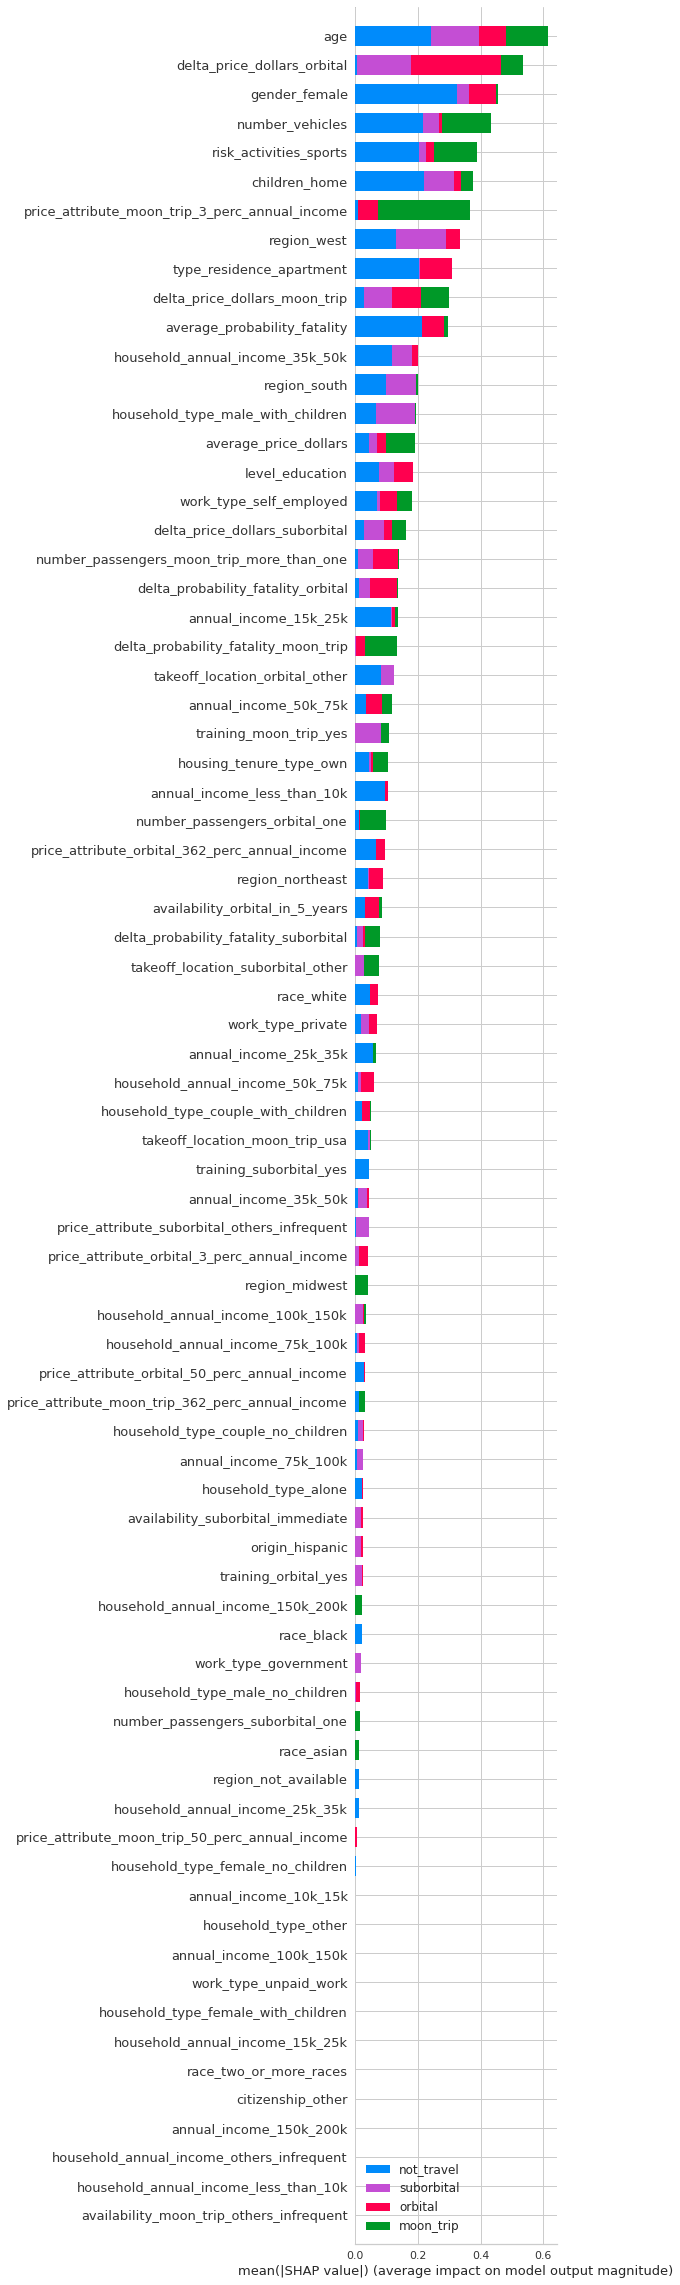

In [58]:
## Visualizing impact of ALL features

# shap TreeExplainer
X_test = get_config('X_test')
explainer = shap.TreeExplainer(tuned_lightgbm)
shap_values = explainer.shap_values(X_test)

# summary plot
shap.summary_plot(
    shap_values,
    X_test,
    max_display=X_test.shape[1],  # 62 columns
    class_names=['moon_trip', 'not_travel', 'orbital', 'suborbital'])


### Keep in mind the label codes:

- moon_trip: 0,
- not_travel: 1,
- orbital: 2,
- suborbital: 3


## Gradient Boosting Classifier


In [59]:
# Best ML analysis
gbc = create_model(estimator='gbc')


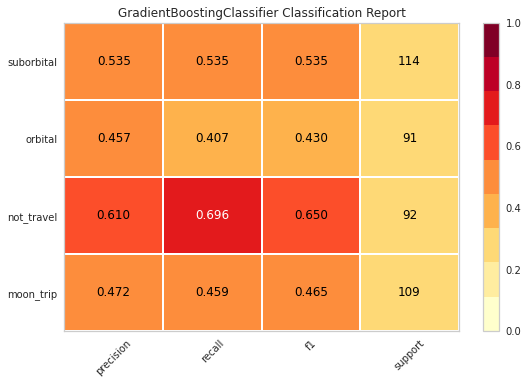

In [60]:
# Plotting the classification report
plot_model(estimator=gbc, plot='class_report', use_train_data=False)


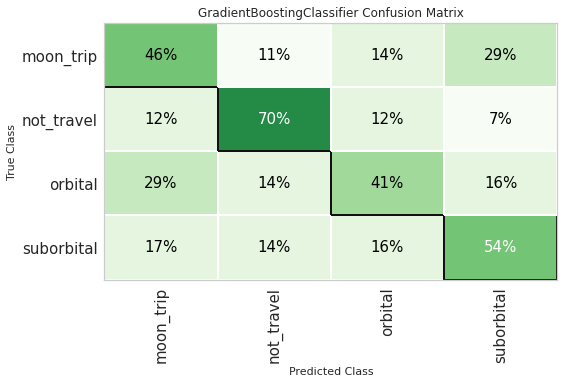

In [61]:
plot_model(gbc,
           plot='confusion_matrix',
           plot_kwargs={'percent': True},
           use_train_data=False)


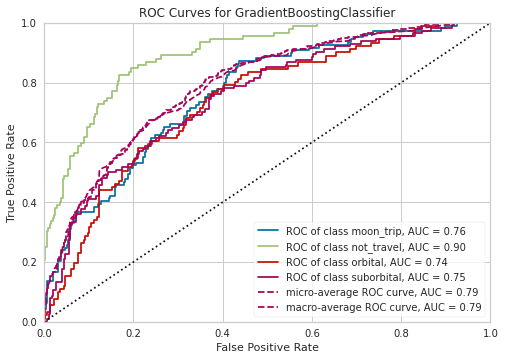

In [62]:
# Plotting the AUC
plot_model(estimator=gbc, plot='auc', use_train_data=False)


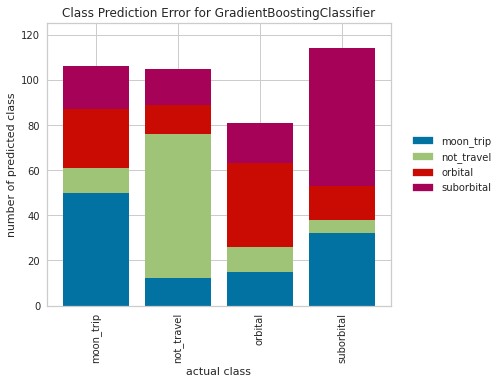

In [63]:
plot_model(estimator=gbc, plot='error')


## Tuned Gradient Boosting Classifier


In [65]:
# tune hyperparameters to optimize AUC
tuned_gbc = tune_model(gbc,
                       optimize='AUC',
                       n_iter=80,
                       early_stopping=True,
                       choose_better=True)


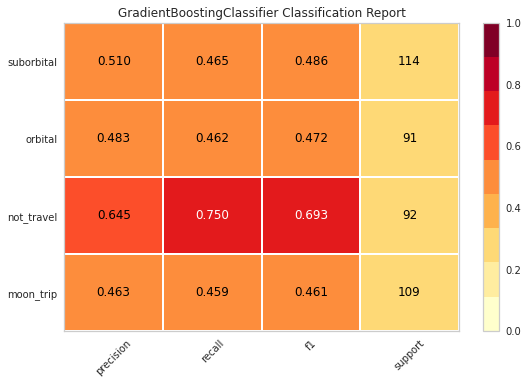

In [66]:
# Plotting the classification report
plot_model(estimator=tuned_gbc, plot='class_report', use_train_data=False)


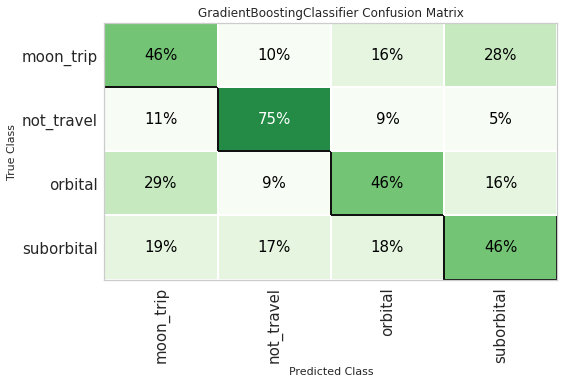

In [67]:
plot_model(tuned_gbc,
           plot='confusion_matrix',
           plot_kwargs={'percent': True},
           use_train_data=False)


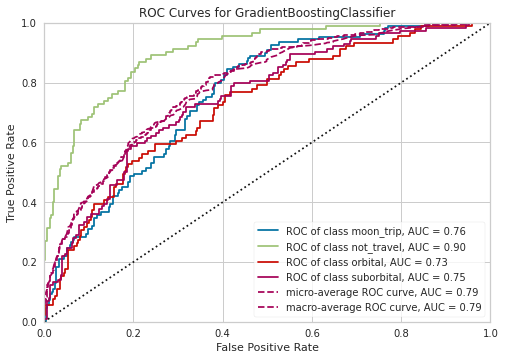

In [68]:
# Plotting the AUC
plot_model(estimator=tuned_gbc, plot='auc', use_train_data=False)


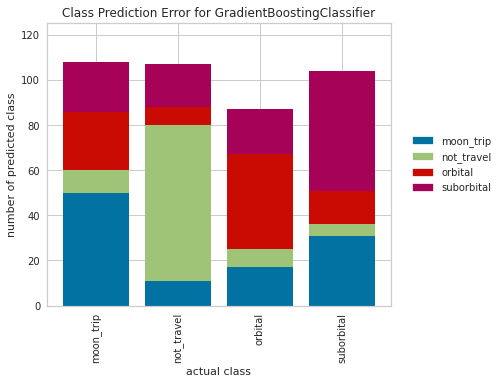

In [69]:
plot_model(estimator=tuned_gbc, plot='error')


## Finalizing and saving model


In [71]:
# finalize a model
final_lightgbm = finalize_model(lightgbm)
final_tuned_lightgbm = finalize_model(tuned_lightgbm)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 

In [72]:
# save a model
save_model(final_lightgbm, base_dir + 'models/lightgbm_jupyter')
save_model(final_tuned_lightgbm, base_dir + 'models/tuned_lightgbm')


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['city', 'state',
                                                        'generation_age',
                                                        'status_in_household'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='choice',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_ca...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=0.8,
                                 impo

# Loading tuned_lightGBM model


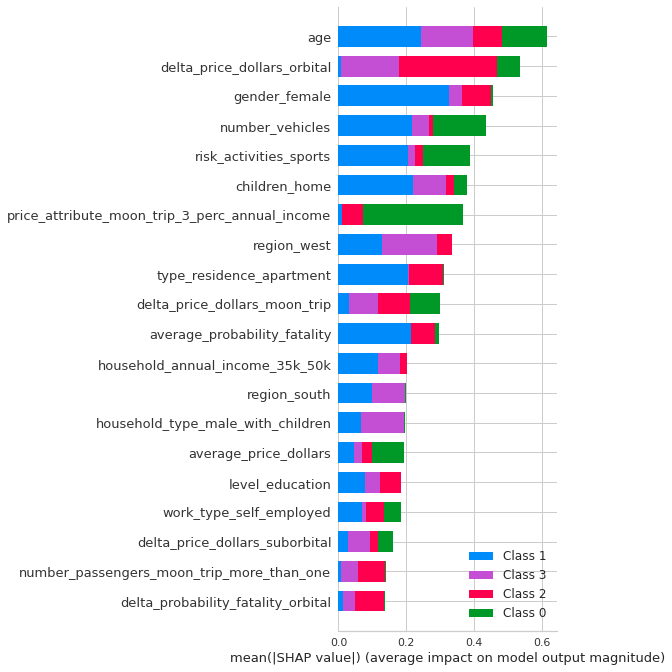

In [73]:
interpret_model(estimator=tuned_lightgbm)

# ValueError: type parameter only accepts 'summary', 'correlation', 'reason', 'pdp', 'msa' or 'pfi'.

In [74]:
from pycaret.classification import *

model = load_model(base_dir + 'models/tuned_lightgbm')
print(model)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['city', 'state',
                                                       'generation_age',
                                                       'status_in_household'],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='choice',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_ca...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.8,

In [75]:
data.head()

choice gender annual_income household_annual_income number_vehicles  \
0   moon_trip   male     100k_150k               150k_200k           1_car   
1  suborbital   male     100k_150k               150k_200k           1_car   
2   moon_trip   male     100k_150k               150k_200k           1_car   
3   moon_trip   male     100k_150k               150k_200k           1_car   
4  suborbital   male     100k_150k               150k_200k           1_car   

    level_education work_type children_home        household_type  \
0  grad_prof_degree   private       1_child  couple_with_children   
1  grad_prof_degree   private       1_child  couple_with_children   
2  grad_prof_degree   private       1_child  couple_with_children   
3  grad_prof_degree   private       1_child  couple_with_children   
4  grad_prof_degree   private       1_child  couple_with_children   

  status_in_household  ... state   region average_probability_fatality  \
0                head  ...    MN  midwest                     2.833333   
1                head  ...    MN  midwest                     2.833333   
2                head  ...    MN  midwest                     2.833333   
3                head  ...    MN  midwest                     5.166667   
4                head  ...    MN  midwest                     2.833333   

  delta_probability_fatality_orbital delta_probability_fatality_suborbital  \
0                           2.333333                             -4.666667   
1                           2.333333                              2.333333   
2                           2.333333                             -4.666667   
3                          -2.333333                             -2.333333   
4                           2.333333                              2.333333   

  delta_probability_fatality_moon_trip average_price_dollars  \
0                             2.333333         303333.333333   
1                            -4.666667         453125.000000   
2                             2.333333         192708.333333   
3                             4.666667          42916.666667   
4                            -4.666667          42916.666667   

  delta_price_dollars_orbital delta_price_dollars_suborbital  \
0              -149791.666667                 -149791.666667   
1                    0.000000                       0.000000   
2              -260416.666667                  130208.333333   
3               -19583.333333                   39166.666667   
4               -19583.333333                  -19583.333333   

  delta_price_dollars_moon_trip  
0                 299583.333333  
1                      0.000000  
2                 130208.333333  
3                 -19583.333333  
4                  39166.666667  

[5 rows x 44 columns]

Classes:  [0 1 2 3]


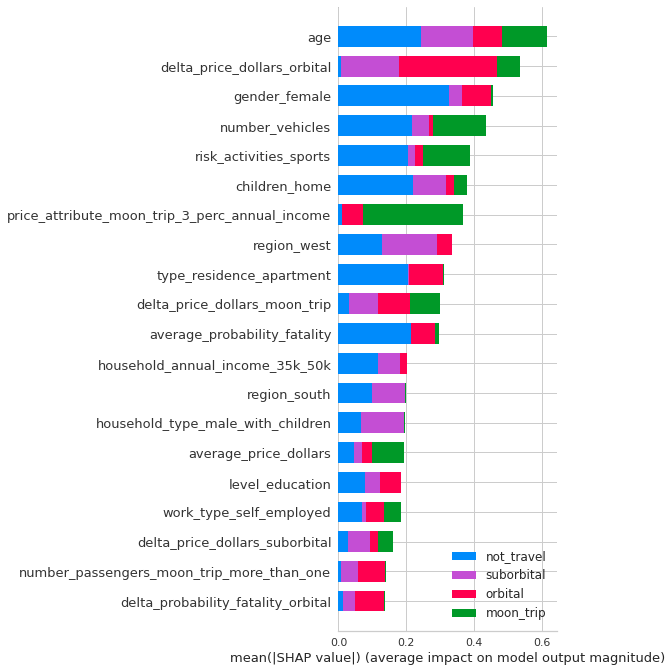

<module 'matplotlib.pyplot' from '/home/juan/.virtualenvs/space_tourism-NTvu09XS/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [76]:
X_test = get_config('X_test')
explainer = shap.TreeExplainer(tuned_lightgbm)
shap_values = explainer.shap_values(X_test)

print('Classes: ', tuned_lightgbm.classes_)

# - moon_trip: 0,
# - not_travel: 1,
# - orbital: 2,
# - suborbital: 3

shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    max_display=20,  # X_test.shape[1] for all features
    class_names=['moon_trip', 'not_travel', 'orbital', 'suborbital'])
plt

In [77]:
# AUC in training (cv) and test sets
model = create_model(estimator='lightgbm')
test_holdout_set = predict_model(estimator=model)
test_holdout_set.head()

number_vehicles  level_education  children_home  risk_activities_sports  \
0              1.0              3.0            2.0                     2.0   
1              1.0              3.0            0.0                     1.0   
2              1.0              3.0            0.0                     1.0   
3              1.0              4.0            2.0                     1.0   
4              2.0              4.0            5.0                     0.0   

        age  average_probability_fatality  delta_probability_fatality_orbital  \
0 -0.014497                      0.663317                           -0.867227   
1 -1.157581                     -0.642387                            0.865091   
2 -0.096146                      0.663317                           -0.867227   
3 -0.586039                     -1.948091                           -0.001068   
4  0.067151                      0.663317                           -0.867227   

   delta_probability_fatality_suborbital  \
0                               1.377970   
1                               0.689197   
2                               1.377970   
3                               0.000425   
4                               1.377970   

   delta_probability_fatality_moon_trip  average_price_dollars  ...  \
0                             -0.802900              -0.550552  ...   
1                             -1.606295              -0.673776  ...   
2                             -0.802900              -0.673776  ...   
3                              0.000495              -0.550552  ...   
4                             -0.802900              -0.282655  ...   

   number_passengers_moon_trip_more_than_one  takeoff_location_moon_trip_usa  \
0                                        1.0                             1.0   
1                                        0.0                             0.0   
2                                        0.0                             1.0   
3                                        1.0                             0.0   
4                                        0.0                             1.0   

   region_midwest  region_northeast  region_not_available  region_south  \
0             0.0               0.0                   0.0           1.0   
1             0.0               0.0                   0.0           0.0   
2             0.0               0.0                   0.0           1.0   
3             0.0               0.0                   0.0           0.0   
4             0.0               0.0                   0.0           1.0   

   region_west      choice       Label   Score  
0          0.0  suborbital     orbital  0.8168  
1          1.0  not_travel  not_travel  0.8830  
2          0.0  suborbital  suborbital  0.8734  
3          1.0   moon_trip  suborbital  0.5756  
4          0.0  not_travel  not_travel  0.9777  

[5 rows x 79 columns]